In [237]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import folium
import geopandas as gpd
import matplotlib.colors as colors
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual, SelectMultiple, RadioButtons, interact, Layout
from helpers import *
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Dataset raw files names

In [238]:
# Crops and livestock
CROPS = 'Production_Crops.csv'
LIVESTOCK = 'Production_Livestock.csv'
VALUE_PROD = 'Value_Production.csv'

In [239]:
# Trade and income
TRADE = 'Trade_Crops_Livestock.csv'
TRADE_MATRIX = 'Trade_Matrix.csv'
INEQUALITY = 'Income_Inequality.csv'
POPULATION = 'Population.xlsx'

In [240]:
# Fertilizers, pesticides, emissions
EMISSIONS = 'Emissions_Agriculture.csv'
FERT_A = 'Fertilizers_Archive.csv'
FERT_N = 'Fertilizers_Nutrient.csv'
FERT_P = 'Fertilizers_Product.csv'
FERT_I = 'Fertilizers_Indicators.csv'
PESTICIDES = 'Pesticides.csv'

In [241]:
# Environment
LAND = 'Land_Use.csv'
WATER = 'Water.csv'
SOIL = 'Soil.csv'
CLIMATE = 'Environment_Temperature.csv'
ENERGY = 'Energy.csv'

In [242]:
# World countries names from geopandas
world_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries = set(world_df['name'])

## Crops Production

We start looking at crops production data.

In [243]:
# Loading the DataSet
crops = pd.read_csv('datasets/'+CROPS, encoding = "ISO-8859-1")

In [244]:
# See how the data is organized
crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,221,"Almonds, with shell",5312,Area harvested,ha,NaN,NaN,NaN,...,12000.0,11029.0,11210.0,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0
1,2,Afghanistan,221,"Almonds, with shell",5419,Yield,hg/ha,NaN,NaN,NaN,...,35000.0,39154.0,49955.0,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
3,2,Afghanistan,711,"Anise, badian, fennel, coriander",5312,Area harvested,ha,NaN,NaN,NaN,...,15000.0,17748.0,17000.0,19500.0,18500.0,18500.0,30000.0,25000.0,26019.0,28873.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5419,Yield,hg/ha,NaN,NaN,NaN,...,6000.0,6203.0,6000.0,6414.0,6757.0,6757.0,7167.0,7200.0,6923.0,6830.0


We now create a function to get all the unique values from the columns `Item`, `Element` and `Unit` in order to better understand what data is contained in the dataset.

In [245]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit', 'Area']:
        print(i)
        print(df[i].unique())

In [246]:
uniquevalues(crops)

Item
['Almonds, with shell' 'Anise, badian, fennel, coriander' 'Apples'
 'Apricots' 'Barley' 'Berries nes' 'Cotton lint' 'Cottonseed' 'Figs'
 'Fruit, citrus nes' 'Fruit, fresh nes' 'Fruit, stone nes' 'Grapes'
 'Linseed' 'Maize' 'Melons, other (inc.cantaloupes)' 'Millet' 'Nuts, nes'
 'Olives' 'Onions, dry' 'Oranges' 'Peaches and nectarines' 'Pears'
 'Pistachios' 'Plums and sloes' 'Potatoes' 'Pulses, nes' 'Rice, paddy'
 'Seed cotton' 'Sesame seed' 'Spices, nes' 'Sugar beet' 'Sugar cane'
 'Sunflower seed' 'Vegetables, fresh nes' 'Walnuts, with shell'
 'Watermelons' 'Wheat' 'Cereals (Rice Milled Eqv)' 'Cereals,Total'
 'Citrus Fruit,Total' 'Coarse Grain, Total' 'Fibre Crops Primary'
 'Fruit Primary' 'Oilcrops, Cake Equivalent' 'Oilcrops, Oil Equivalent'
 'Pulses,Total' 'Roots and Tubers,Total' 'Treenuts,Total'
 'Vegetables Primary' 'Beans, dry' 'Beans, green'
 'Broad beans, horse beans, dry' 'Cabbages and other brassicas'
 'Carrots and turnips' 'Cauliflowers and broccoli' 'Cherries'
 'Cherr

As we can see, in the `Item` column, the kind of vegetable or fruit considered is reported, as well as total values for some categories. In the `Element` columns we have instead either the harvested area, the amount produced, or the yield, which is the harvested production per unit of harvested area, for all the crop products.

For each `Element` there is a different unit parameter (as stated in the FAO website): 
- Production : tonnes
- Area harvested: hectares
- Yield: tonnes per hectare.

We decided to keep and separate data for Production and for Yield, because this features are more significant for the purpose of the project in general.

In [247]:
# Save data in a new DataFrame and see the result
crops_production = crops[crops['Element']=='Production']
crops_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,221,"Almonds, with shell",5510,Production,tonnes,NaN,NaN,NaN,...,42000.0,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5510,Production,tonnes,NaN,NaN,NaN,...,9000.0,11008.0,10200.0,12508.0,12500.0,12500.0,21500.0,18000.0,18012.0,19719.0
8,2,Afghanistan,515,Apples,5510,Production,tonnes,15100.0,15100.0,15100.0,...,56061.0,72765.0,59850.0,62041.0,70000.0,78597.0,89403.0,89733.0,140903.0,175000.0
11,2,Afghanistan,526,Apricots,5510,Production,tonnes,32000.0,32000.0,32000.0,...,59559.0,60000.0,66560.0,67995.0,83500.0,90000.0,90000.0,87686.0,17894.0,131816.0
14,2,Afghanistan,44,Barley,5510,Production,tonnes,378000.0,378000.0,378000.0,...,333000.0,486000.0,437000.0,305900.0,504000.0,514000.0,521000.0,403000.0,301856.0,94995.0


In [248]:
# Check that we have a unique unit now
crops_production.Unit.unique()

array(['tonnes'], dtype=object)

Considering the `Area` column, we can see that there are rows that actually represent a region and not a specific Country: we want to drop these columns. There are also some countries that have changed over time such as Sudan that is classified as Sudan and Sudan(former). We want to collect the data and refer it to a unique country.

Since the ultimate goal is to obtain a colormap of the world, we use the GeoPandas package. We then change the names of all the countries that have different names from the ones used by GeoPandas (e.g. 'Bosnia and Herzegovina' is replaced by 'Bosnia and Herz.').

In [249]:
# Define country names changes
changes = {'Area' : {'Bosnia and Herzegovina' : 'Bosnia and Herz.' ,
                    'Brunei Darussalam' : 'Brunei',
                    'Czechoslovakia' : 'Czechia',
                    'Republic of Korea' : 'South Korea',
                    "Democratic People's Republic of Korea" : 'North Korea',
                    'Democratic Republic of the Congo' : 'Dem. Rep. Congo',
                    'Bolivia (Plurinational State of)' : 'Bolivia',
                    'Venezuela (Bolivarian Republic of)' : 'Venezuela',
                    'Republic of Moldova' : 'Moldova',
                    'Dominican Republic' : 'Dominican Rep.',
                    'Equatorial Guinea' : 'Eq. Guinea',
                    'Eswatini' : 'eSwatini',
                    'Ethiopia PDR' : 'Ethiopia',
                    'Iran (Islamic Republic of)' :'Iran',
                    'Serbia and Montenegro' : 'Serbia',
                    'Sudan (former)' : 'Sudan',
                    'South Sudan' : 'S. Sudan',
                    'Syrian Arab Republic' : 'Syria',
                    'The former Yugoslav Republic of Macedonia' : 'Macedonia',
                    'United Republic of Tanzania' : 'Tanzania',
                    'Viet Nam' : 'Vietnam',
                    'Russian Federation' : 'Russia',
                    'Central African Republic' : 'Central African Rep.',
                    'USSR' : 'Russia'
                    }}

In [250]:
# Apply country names changes
crops_production = crops_production.replace(changes)

Since the dataset already contains in the `Item` column some total values for different categories, we could extract only those values. Moreover, all the production is reported in terms of tonnes, and so we can also report the total production (as a first approximation: we don't know exactly if all products are considered in those categories, or if some product is considered in more than one category).

We consider the following categories (with respective codes):
* 1717: `Cereals`
* 1720: `Roots and tubers`
* 1726: `Pulses`
* 1732: `Oilcrops`
* 1735: `Vegetables`
* 1738: `Fruit`
* 1753: `Fibre crops`

Therefore we select each category, group by the `Area` and sum the values (if necessary for some reasons).

In [251]:
# Keep only interesting items
item_code_list = [1717, 1720, 1726, 1732, 1735, 1738, 1753]
crops_production = crops_production.loc[crops_production['Item Code'].map(lambda x: x in item_code_list),]

In [252]:
# Calculate the total production
crops_production = crops_production.groupby(['Area','Item']).sum()
to_drop = ['Area Code','Item Code','Element Code']
crops_production = crops_production.drop(to_drop, axis=1)

In [253]:
# Check the result
crops_production.head(8)

Y1961       Y1962       Y1963  \
Area        Item                                                           
Afghanistan Cereals,Total              3695000.0   3696000.0   3378000.0   
            Fibre Crops Primary          17000.0     26000.0     36700.0   
            Fruit Primary               567200.0    565000.0    571700.0   
            Oilcrops, Oil Equivalent     24700.0     28366.0     31752.0   
            Pulses,Total                 18000.0     18600.0     19600.0   
            Roots and Tubers,Total      130000.0    115000.0    122000.0   
            Vegetables Primary          291300.0    306300.0    324600.0   
Africa      Cereals,Total             46310719.0  53093043.0  54568632.0   

                                           Y1964       Y1965       Y1966  \
Area        Item                                                           
Afghanistan Cereals,Total              3732000.0   3785000.0   3489000.0   
            Fibre Crops Primary          26000.0     25000.0     20300.0   
            Fruit Primary               663800.0    715200.0    778700.0   
            Oilcrops, Oil Equivalent     28366.0     28796.0     28524.0   
            Pulses,Total                 20600.0     21700.0     22600.0   
            Roots and Tubers,Total      129000.0    132000.0    136000.0   
            Vegetables Primary          342900.0    357500.0    361200.0   
Africa      Cereals,Total             51412170.0  51977920.0  48640817.0   

                                           Y1967       Y1968       Y1969  \
Area        Item                                                           
Afghanistan Cereals,Total              3826000.0   3916000.0   4038000.0   
            Fibre Crops Primary          23100.0     23700.0     28700.0   
            Fruit Primary               913000.0    922000.0    933300.0   
            Oilcrops, Oil Equivalent     29380.0     30199.0     32352.0   
            Pulses,Total                 15000.0     24600.0     25600.0   
            Roots and Tubers,Total      147000.0    150000.0    154000.0   
            Vegetables Primary          391000.0    401100.0    411400.0   
Africa      Cereals,Total             61377334.0  58004204.0  59892553.0   

                                           Y1970  ...        Y2008  \
Area        Item                                  ...                
Afghanistan Cereals,Total              3512000.0  ...    3950000.0   
            Fibre Crops Primary          25300.0  ...      11550.0   
            Fruit Primary               893000.0  ...    1244514.0   
            Oilcrops, Oil Equivalent     30146.0  ...      19705.0   
            Pulses,Total                 26700.0  ...      51000.0   
            Roots and Tubers,Total      144000.0  ...     280000.0   
            Vegetables Primary          383600.0  ...    1009392.0   
Africa      Cereals,Total             60471209.0  ...  155008796.0   

                                            Y2009        Y2010        Y2011  \
Area        Item                                                              
Afghanistan Cereals,Total               6514000.0    5957000.0    4681020.0   
            Fibre Crops Primary           14148.0      10890.0      10890.0   
            Fruit Primary               1459939.0    1360109.0    1274114.0   
            Oilcrops, Oil Equivalent      20717.0      19318.0      19620.0   
            Pulses,Total                  50000.0      53300.0      67000.0   
            Roots and Tubers,Total       302400.0     246000.0     205000.0   
            Vegetables Primary          1022578.0     969763.0     762948.0   
Africa      Cereals,Total             159397073.0  166591022.0  163289748.0   

                                            Y2012        Y2013        Y2014  \
Area        Item                                                              
Afghanistan Cereals,Total               6379000.0    6520329.0    6748125.0   
            Fibre Crops Primary

In the FAO's Datasets we have several information related to areas which are not state (e.g. `Europe`). We don't need this information, so drop those columns and keep only countries who appear in GeoPandas.

In [254]:
# Delete useless Areas
crops_production = crops_production.reset_index().set_index('Area')
to_delete = set(crops_production.index).difference(countries)
crops_production = crops_production.drop(to_delete, axis=0)

In [255]:
# Check the result
crops_production.head()

,Item,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,"Cereals,Total",3695000.0,3696000.0,3378000.0,3732000.0,3785000.0,3489000.0,3826000.0,3916000.0,4038000.0,...,3950000.0,6514000.0,5957000.0,4681020.0,6379000.0,6520329.0,6748125.0,5809811.0,5534902.0,4897143.0
Afghanistan,Fibre Crops Primary,17000.0,26000.0,36700.0,26000.0,25000.0,20300.0,23100.0,23700.0,28700.0,...,11550.0,14148.0,10890.0,10890.0,11979.0,13917.0,14000.0,0.0,0.0,0.0
Afghanistan,Fruit Primary,567200.0,565000.0,571700.0,663800.0,715200.0,778700.0,913000.0,922000.0,933300.0,...,1244514.0,1459939.0,1360109.0,1274114.0,1352528.0,1346187.0,1714567.0,1832632.0,2602757.0,2496509.0
Afghanistan,"Oilcrops, Oil Equivalent",24700.0,28366.0,31752.0,28366.0,28796.0,28524.0,29380.0,30199.0,32352.0,...,19705.0,20717.0,19318.0,19620.0,19965.0,23083.0,23302.0,0.0,0.0,0.0
Afghanistan,"Pulses,Total",18000.0,18600.0,19600.0,20600.0,21700.0,22600.0,15000.0,24600.0,25600.0,...,51000.0,50000.0,53300.0,67000.0,69000.0,60000.0,60000.0,106842.0,82866.0,37287.0


To better analyze data later, we compute and store the World total output, summing up all values in each column, ad well as total output for each country. We store them in a separate dataset.

In [256]:
# Production total dataset
crops_production_total = crops_production.reset_index().groupby('Area').sum()
crops_production_total

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,4743200.0,4755266.0,4484352.0,4942666.0,5065196.0,4836324.0,5344480.0,5467599.0,5623352.0,5014746.0,...,6566161.0,9383782.0,8616380.0,7020592.0,8880216.0,9056763.0,9877315.0,9093255.0,10112058.0,8861701.0
Albania,598955.0,607975.0,588683.0,691408.0,655436.0,824860.0,877709.0,952096.0,969437.0,1029502.0,...,1869948.0,1950198.0,2184214.0,2310271.0,2367863.0,2370162.0,2404778.0,2484597.0,2608621.0,2632998.0
Algeria,4153242.0,5479839.0,5444759.0,4365933.0,4986160.0,2960192.0,3833126.0,5000484.0,4580661.0,4875845.0,...,11391128.0,16902753.0,17605105.0,19166509.0,20988630.0,22763876.0,19967489.0,20690811.0,20856074.0,21052739.0
Angola,2531790.0,2601724.0,2639703.0,2752428.0,2842092.0,2869890.0,2934173.0,2983079.0,3214197.0,3217989.0,...,14870652.0,19274936.0,20579450.0,22077718.0,16852421.0,25015776.0,17725925.0,17999372.0,21055285.0,23789048.0
Argentina,23802543.0,22909816.0,26605069.0,30013076.0,24050707.0,26992475.0,30928549.0,26597164.0,29440803.0,31564828.0,...,69606161.0,46668585.0,64766901.0,77153736.0,71077387.0,75839125.0,76596560.0,71038426.0,75497059.0,90876961.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vietnam,14816414.0,15804589.0,15732983.0,15877184.0,15561370.0,14585129.0,15397932.0,14628828.0,15181543.0,16619403.0,...,69637322.0,68901070.0,71098034.0,74036311.0,81872670.0,83208320.0,85710015.0,86290359.0,84894366.0,84826847.0
Yemen,1186302.0,1217068.0,1252066.0,1278089.0,1286318.0,1213205.0,1207471.0,1196899.0,1182411.0,1097356.0,...,2845457.0,2860524.0,3333026.0,2905744.0,3171907.0,3015058.0,2811305.0,2380555.0,2178716.0,2338350.0
Zambia,1116974.0,1109102.0,1037363.0,1135597.0,1179918.0,1312807.0,1327883.0,1263704.0,1282359.0,1153474.0,...,3303223.0,4244643.0,5213013.0,5391932.0,5261017.0,4946902.0,5467838.0,4607190.0,4998833.0,5783554.0


In [257]:
sumCol = crops_production_total.sum().rename("World")

We now define a new function, called `norm`, which gives us the "weight" of each country relative to the total world output: we compute weigths for each country on a multiple years window and then take the mean weight.

In [258]:
# Define the function norm
def norm(col):
    return col/col.sum()

In [259]:
# Define years for window
years = ['Y'+str(2000+x) for x in range(0,18)]

In [260]:
# Apply the norm function
crops_production_total['Recent'] = crops_production_total[years].apply(norm).mean(axis=1)*100

In [261]:
crops_production_total.Recent.head()

Area
Afghanistan    0.150717
Albania        0.038924
Algeria        0.296906
Angola         0.301857
Argentina      1.300562
Name: Recent, dtype: float64

In [262]:
# Append World total
crops_production_total = crops_production_total.append(sumCol)

We are interested to look at the countries which are more involved in production.

In [263]:
# Sort by Recent column
crops_production_total = crops_production_total.sort_values(by=['Recent'], ascending=0)
crops_production_total.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,276020520.0,292379486.0,292696862.0,300876135.0,332933763.0,360293459.0,365039233.0,362094242.0,372109515.0,401194069.0,...,1.311763e+09,1.360883e+09,1.423125e+09,1.460292e+09,1.494247e+09,1.520296e+09,1.589480e+09,1.600691e+09,1.624348e+09,25.911355
United States of America,222397018.0,222258492.0,232416678.0,216903600.0,244919194.0,246089717.0,271456398.0,267206996.0,272265045.0,253506749.0,...,5.295446e+08,5.098412e+08,4.922584e+08,4.675590e+08,5.427622e+08,5.561056e+08,5.176926e+08,5.634938e+08,5.238241e+08,9.847533
India,143598339.0,142876646.0,147780369.0,151078002.0,141044058.0,141544004.0,157508240.0,169787874.0,174851650.0,184556376.0,...,4.866994e+08,5.260331e+08,5.583190e+08,5.703380e+08,5.920575e+08,6.065391e+08,5.620291e+08,5.773180e+08,6.105340e+08,9.813684
Brazil,47614280.0,51171329.0,55164956.0,57507149.0,63281362.0,61035248.0,67830002.0,70542405.0,72107719.0,75444944.0,...,1.642266e+08,1.727394e+08,1.810961e+08,1.852343e+08,1.966343e+08,2.006915e+08,1.855449e+08,1.609482e+08,1.933223e+08,3.277382
Indonesia,34318545.0,37683553.0,35291415.0,39045392.0,37665280.0,38262085.0,35823780.0,41598839.0,41416505.0,43524160.0,...,1.604917e+08,1.651935e+08,1.679491e+08,1.780512e+08,1.800578e+08,1.823326e+08,1.519265e+08,1.571552e+08,1.630821e+08,2.881158


We can now visualize the result using GeoPandas and Folium.

In [264]:
# function mapp for World Maps
def mapp(result, result_name, world_df=world_df, quant = 0.95):
    plot_name = result.name
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=[plot_name])
    vmin, vmax, vcenter = merged[plot_name].min(), merged[plot_name].max(), merged[plot_name].quantile(quant)
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column=plot_name, figsize=(15,10),  k=9, norm=divnorm, cmap='OrRd', linewidth=1, edgecolor = "black",
                     legend=True, legend_kwds={'orientation': "horizontal"})
    ax.set_title(result_name)
    return

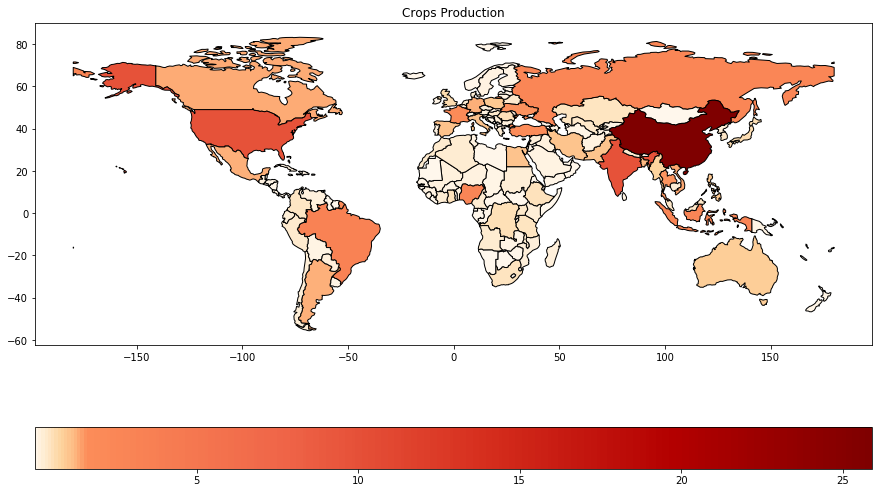

In [265]:
# World map
mapp(crops_production_total.Recent,'Crops Production')

We then define the functions `clean_df_items` and `clean_df` that do the cleaning we have seen so far. **We also save them in the helpers.py file**.

In [266]:
# clean_df_items function
def clean_df_items(df, items_list, to_drop, changes):
    df = df.replace(changes)
    df = df.loc[df['Item Code'].map(lambda x: x in items_list),]
    df = df.groupby(['Area','Item']).sum()
    df = df.drop(to_drop, axis=1)
    df = df.reset_index().set_index('Area')
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    df = df.reset_index().set_index(['Area','Item'])
    return df

In [267]:
# Check if it works
crops_production = crops[crops['Element']=='Production']
crops_production = clean_df_items(crops_production,item_code_list,to_drop,changes)
crops_production.head()

Y1961      Y1962      Y1963  \
Area        Item                                                        
Afghanistan Cereals,Total             3695000.0  3696000.0  3378000.0   
            Fibre Crops Primary         17000.0    26000.0    36700.0   
            Fruit Primary              567200.0   565000.0   571700.0   
            Oilcrops, Oil Equivalent    24700.0    28366.0    31752.0   
            Pulses,Total                18000.0    18600.0    19600.0   

                                          Y1964      Y1965      Y1966  \
Area        Item                                                        
Afghanistan Cereals,Total             3732000.0  3785000.0  3489000.0   
            Fibre Crops Primary         26000.0    25000.0    20300.0   
            Fruit Primary              663800.0   715200.0   778700.0   
            Oilcrops, Oil Equivalent    28366.0    28796.0    28524.0   
            Pulses,Total                20600.0    21700.0    22600.0   

                                          Y1967      Y1968      Y1969  \
Area        Item                                                        
Afghanistan Cereals,Total             3826000.0  3916000.0  4038000.0   
            Fibre Crops Primary         23100.0    23700.0    28700.0   
            Fruit Primary              913000.0   922000.0   933300.0   
            Oilcrops, Oil Equivalent    29380.0    30199.0    32352.0   
            Pulses,Total                15000.0    24600.0    25600.0   

                                          Y1970  ...      Y2008      Y2009  \
Area        Item                                 ...                         
Afghanistan Cereals,Total             3512000.0  ...  3950000.0  6514000.0   
            Fibre Crops Primary         25300.0  ...    11550.0    14148.0   
            Fruit Primary              893000.0  ...  1244514.0  1459939.0   
            Oilcrops, Oil Equivalent    30146.0  ...    19705.0    20717.0   
            Pulses,Total                26700.0  ...    51000.0    50000.0   

                                          Y2010      Y2011      Y2012  \
Area        Item                                                        
Afghanistan Cereals,Total             5957000.0  4681020.0  6379000.0   
            Fibre Crops Primary         10890.0    10890.0    11979.0   
            Fruit Primary             1360109.0  1274114.0  1352528.0   
            Oilcrops, Oil Equivalent    19318.0    19620.0    19965.0   
            Pulses,Total                53300.0    67000.0    69000.0   

                                          Y2013      Y2014      Y2015  \
Area        Item                                                        
Afghanistan Cereals,Total             6520329.0  6748125.0  5809811.0   
            Fibre Crops Primary         13917.0    14000.0        0.0   
            Fruit Primary             1346187.0  1714567.0  1832632.0   
            Oilcrops, Oil Equivalent    23083.0    23302.0        0.0   
            Pulses,Total                60000.0    60000.0   106842.0   

                                          Y2016      Y2017  
Area        Item                                            
Afghanistan Cereals,Total             5534902.0  4897143.0  
            Fibre Crops Primary             0.0        0.0  
            Fruit Primary             2602757.0  2496509.0  
            Oilcrops, Oil Equivalent        0.0        0.0  
            Pulses,Total                82866.0    37287.0  

[5 rows x 57 columns]

In [268]:
# clean_df function
def clean_df(df, years, to_drop, changes):
    df = df.replace(changes)
    df = df.groupby('Area').sum()
    df = df.drop(to_drop, axis=1)
    to_delete = set(df.index).difference(countries)
    df = df.drop(to_delete, axis=0)
    sumCol = df.sum().rename("World")
    df['Recent'] = df[years].apply(norm).mean(axis=1)*100
    df = df.append(sumCol)
    df = df.sort_values(by=['Recent'], ascending=0)
    return df

In [269]:
# Save data to pickle files
crops_production.to_pickle("pickle/crops_production.pkl")
crops_production_total.to_pickle("pickle/crops_production_total.pkl")

We now save and keep data related to yield.

In [270]:
# Load dataset
crops_yield = crops[crops['Element']=='Yield']

In [271]:
# Select interesting items
item_code_list = [1717, 1720, 1726, 1732, 1735, 1738, 1753]
crops_yield = crops_yield.loc[crops_yield['Item Code'].map(lambda x: x in item_code_list),]

In [272]:
# Clean dataframe
years = ['Y'+str(2000+x) for x in range(0,18)]
crops_yield = clean_df(crops_yield,years,to_drop,changes)

We drop the column `Recent` in this case, since it does not make sense for data about yield (productivity).

In [273]:
# Drop Recent column
crops_yield = crops_yield.drop(columns='Recent')

In [274]:
crops_yield.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Netherlands,10309213.0,8709157.0,11397142.0,20590999.0,15869033.0,17581410.0,21955184.0,20916277.0,26255165.0,30952516.0,...,1450537.0,1587502.0,1487264.0,1600585.0,1496329.0,1534360.0,1611168.0,1487763.0,1457313.0,1472804.0
Kuwait,469949.0,494779.0,494243.0,485248.0,539018.0,520494.0,540584.0,507009.0,487662.0,466530.0,...,1104809.0,1058074.0,1106851.0,1500985.0,1451111.0,1522896.0,1758175.0,1809033.0,1762580.0,1598256.0
Belgium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1194044.0,1269878.0,1304604.0,1286455.0,1235339.0,1297026.0,1448125.0,1268449.0,1107078.0,1129165.0
United States of America,533914.0,548717.0,549607.0,533761.0,575279.0,574080.0,585626.0,587825.0,616171.0,620028.0,...,1078980.0,1118378.0,1087011.0,1098452.0,1107395.0,1125513.0,1134756.0,1126368.0,1136791.0,1118692.0
Iceland,481801.0,451553.0,435457.0,464066.0,544856.0,470150.0,509220.0,499624.0,449591.0,450091.0,...,1279426.0,1270472.0,1311136.0,1226944.0,1262965.0,1436276.0,1384170.0,1296796.0,1391299.0,1278578.0


In [275]:
# Save to pickle
crops_yield.to_pickle("pickle/crops_yield.pkl")

## Live Stock

We now consider the dataset related to `livestock`. For this analysis, we repeat more or less the same steps done before, in order to have a clear visualization of the phenomenon.

In [276]:
# Load dataset
livestock = pd.read_csv('datasets/'+LIVESTOCK, encoding = "ISO-8859-1")

In [277]:
livestock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,1062,"Eggs, hen, in shell",5313,Laying,1000 Head,4000.0,4400.0,4600.0,...,9100.0,8700.0,8200.0,9600.0,9500.0,9500.0,9500.0,9337.0,9369.0,10688.0
1,2,Afghanistan,1062,"Eggs, hen, in shell",5410,Yield,100mg/An,25000.0,25000.0,25000.0,...,18349.0,19285.0,19932.0,17927.0,18947.0,18947.0,19474.0,21253.0,21263.0,18713.0
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
3,2,Afghanistan,1067,"Eggs, hen, in shell (number)",5513,Production,1000 No,200000.0,220000.0,230000.0,...,333960.0,335560.0,326880.0,344200.0,360000.0,360000.0,370000.0,396880.0,398420.0,400000.0
4,2,Afghanistan,919,"Hides, cattle, fresh",5320,Producing Animals/Slaughtered,Head,360000.0,384000.0,396000.0,...,739000.0,750000.0,727800.0,766700.0,772000.0,744500.0,NaN,NaN,NaN,NaN


As for the `crops` dataset, we are interested in the `Production` only.

In [278]:
# Keep production only
livestock = livestock[livestock['Element']=='Production']

We now look at data in tonnes, i.e. `Unit` = `tonnes`.

In [279]:
# Select data in tonnes
livestock = livestock[livestock['Unit']=='tonnes']
livestock.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
2,2,Afghanistan,1062,"Eggs, hen, in shell",5510,Production,tonnes,10000.0,11000.0,11500.0,...,16698.0,16778.0,16344.0,17210.0,18000.0,18000.0,18500.0,19844.0,19921.0,20000.0
6,2,Afghanistan,919,"Hides, cattle, fresh",5510,Production,tonnes,7200.0,7680.0,7920.0,...,14780.0,15000.0,14556.0,15334.0,15440.0,14890.0,NaN,NaN,NaN,NaN
7,2,Afghanistan,1182,"Honey, natural",5510,Production,tonnes,2000.0,2000.0,2000.0,...,2800.0,2800.0,2000.0,2000.0,2000.0,2000.0,1802.0,1697.0,1584.0,1470.0
10,2,Afghanistan,1137,"Meat indigenous, camel",5510,Production,tonnes,3600.0,4031.0,5031.0,...,3780.0,3960.0,3960.0,3564.0,3600.0,3510.0,NaN,NaN,NaN,NaN
13,2,Afghanistan,944,"Meat indigenous, cattle",5510,Production,tonnes,42984.0,45811.0,47243.0,...,132342.0,134133.0,130922.0,138002.0,137723.0,117829.0,NaN,NaN,NaN,NaN


As for the previous dataset, in the `Item` columns, total productions for some categories are already computed, in particular:
* 1780: Milk, Total
* 1783: Eggs, Primary
* 1806: Beef and Buffalo Meat
* 1807: Sheep and Goat Meat
* 1808: Meat, poultry

In [280]:
# Define recent years and columns to drop
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

In [281]:
# Clean dataset
item_code_list = set([1780,1783,1806,1807,1808])
livestock_production = clean_df_items(livestock,item_code_list,to_drop,changes)
livestock_production.head()

Y1961     Y1962     Y1963     Y1964  \
Area        Item                                                            
Afghanistan Beef and Buffalo Meat   43000.0   45800.0   47250.0   48000.0   
            Eggs Primary            10000.0   11000.0   11500.0   12000.0   
            Meat, Poultry            5600.0    6000.0    6160.0    6400.0   
            Milk,Total             574900.0  576700.0  646700.0  659900.0   
            Sheep and Goat Meat     73220.0   72375.0   75530.0   79750.0   

                                      Y1965     Y1966     Y1967     Y1968  \
Area        Item                                                            
Afghanistan Beef and Buffalo Meat   48700.0   68000.0   65000.0   71000.0   
            Eggs Primary            12800.0   13200.0   15000.0   13900.0   
            Meat, Poultry            6800.0    7200.0    7600.0    8000.0   
            Milk,Total             720900.0  750500.0  819000.0  856000.0   
            Sheep and Goat Meat     84375.0   89690.0  100312.0  111312.0   

                                      Y1969     Y1970  ...      Y2008  \
Area        Item                                       ...              
Afghanistan Beef and Buffalo Meat   75000.0   62000.0  ...   133000.0   
            Eggs Primary            15000.0   13700.0  ...    16698.0   
            Meat, Poultry            9600.0    9600.0  ...    20800.0   
            Milk,Total             856000.0  750000.0  ...  1707200.0   
            Sheep and Goat Meat    106312.0  106200.0  ...   128480.0   

                                       Y2009      Y2010      Y2011      Y2012  \
Area        Item                                                                
Afghanistan Beef and Buffalo Meat   135000.0   131000.0   138000.0   139000.0   
            Eggs Primary             16778.0    16344.0    17210.0    18000.0   
            Meat, Poultry            20000.0    28000.0    25600.0    24800.0   
            Milk,Total             1732000.0  1721000.0  1743000.0  1844700.0   
            Sheep and Goat Meat     137380.0   157200.0   160500.0   155200.0   

                                       Y2013      Y2014      Y2015      Y2016  \
Area        Item                                                                
Afghanistan Beef and Buffalo Meat   134000.0   120873.0   110225.0   104515.0   
            Eggs Primary             18000.0    18500.0    19844.0    19921.0   
            Meat, Poultry            26400.0    24824.0    24573.0    24434.0   
            Milk,Total             1835200.0  2415960.0  2198334.0  2188394.0   
            Sheep and Goat Meat     150200.0   154327.0   155823.0   153717.0   

                                       Y2017  
Area        Item                              
Afghanistan Beef and Buffalo Meat    93690.0  
            Eggs Primary             20000.0  
            Meat, Poultry            27871.0  
            Milk,Total             2115642.0  
            Sheep and Goat Meat     159348.0  

[5 rows x 57 columns]

It could be interesting to build also a general dataset, in which all production in livestock is summed together without distinction, to have an overall view of the phenomenon.

In [282]:
# Clean dataset
livestock_total = livestock_production.reset_index()
livestock_total = clean_df(livestock_total,years,[],changes)

In [283]:
livestock_total.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
India,22037091.0,21806599.0,21678865.0,21314142.0,21065561.0,21223200.0,21784768.0,23166077.0,23608780.0,22858008.0,...,125251973.0,130991610.0,137419319.0,142323747.0,147941518.0,157027124.0,166547514.0,176592925.0,187922016.0,13.230856
United States of America,71824579.0,72040876.0,72151526.0,74099083.0,73168988.0,72012278.0,72002074.0,71390025.0,71139100.0,72124146.0,...,122363333.0,124448148.0,126371568.0,128427797.0,129045628.0,131643886.0,132275684.0,135451594.0,137917957.0,13.048444
China,4241253.0,4353915.0,4481562.0,4613489.0,4762512.0,4894731.0,4991887.0,4965832.0,5119467.0,5269604.0,...,94983825.0,96936629.0,98504053.0,100702360.0,99109326.0,100948069.0,100930977.0,103382472.0,102595942.0,9.121826
Brazil,7055071.0,7299352.0,7444218.0,8343820.0,8905887.0,8992675.0,9091538.0,9653654.0,9861946.0,10040091.0,...,50822812.0,53459992.0,55619040.0,56303001.0,59189006.0,60659161.0,60535929.0,59601074.0,60333994.0,5.250019
Russia,68897008.0,70781008.0,68509000.0,69990000.0,79823784.0,83827488.0,88672816.0,91662644.0,90995588.0,92753000.0,...,39012115.0,38590782.0,38654815.0,39246277.0,38119661.0,38761980.0,39120754.0,39169700.0,39976181.0,4.114270


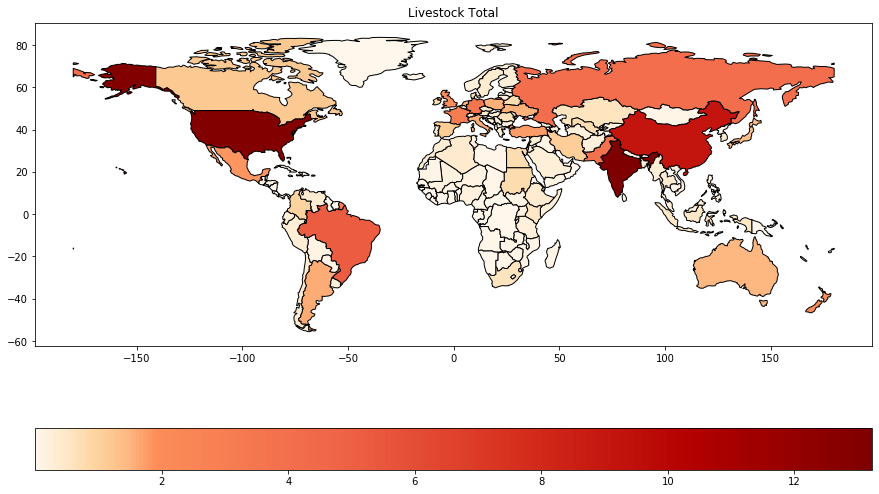

In [284]:
# World map
mapp(livestock_total.Recent,'Livestock Total')

In [285]:
# Save in pickle format
livestock_production.to_pickle("pickle/livestock_production.pkl")
livestock_total.to_pickle("pickle/livestock_total.pkl")

# Production Value

In [286]:
# Load dataset
value_production = pd.read_csv('datasets/'+VALUE_PROD, encoding = "ISO-8859-1")

In [287]:
value_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
0,2,Afghanistan,221,"Almonds, with shell",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
1,2,Afghanistan,221,"Almonds, with shell",154,Net Production Value (constant 2004-2006 1000 I$),1000 Int. $,NaN,NaN,NaN,...,92899.455089,123940.698000,127431.694327,165254.264000,178861.182059,182960.078000,124575.156335,80856.550600,71549.194374,96918.674867
2,2,Afghanistan,221,"Almonds, with shell",56,Gross Production Value (current million SLC),SLC,NaN,NaN,NaN,...,5433.830473,8980.020000,8032.038000,12079.200000,13995.079900,14911.000000,9230.459191,5563.109132,4824.773367,6050.024466
3,2,Afghanistan,221,"Almonds, with shell",55,Gross Production Value (constant 2004-2006 mil...,SLC,NaN,NaN,NaN,...,3280.355179,4376.446667,4499.716581,5835.262222,6315.733546,6460.468889,4398.849906,2855.110444,2526.460140,3422.277092
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",152,Gross Production Value (constant 2004-2006 100...,1000 Int. $,NaN,NaN,NaN,...,93962.672000,49744.944000,57275.009778,56377.603200,64207.463034,69090.200000,69090.200000,73114.852434,79457.968291,77478.699955


In this case, we choose to focus on the `Gross Production Value`: other data from these dataset may turn out to be useful later.

In [288]:
# Select interesting data
value_production = value_production[value_production['Element']=='Gross Production Value (current million US$)']

Since we don't have in this dataset all the aggregate data as we had for production quantities, we will proceed by discarding the aggregate record which are present and then summing up all products. By direct inspection and reading general information on methodology on FAO website, we infer that aggregate data have usually`Item Code` values above 1500.

In [289]:
value_production = value_production[value_production['Item Code']<1500]
value_production.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016
244,3,Albania,515,Apples,57,Gross Production Value (current million US$),USD,NaN,NaN,NaN,...,17.516719,21.455492,21.867015,19.438302,24.738601,26.362336,37.267053,38.963480,35.686214,38.714933
250,3,Albania,526,Apricots,57,Gross Production Value (current million US$),USD,NaN,NaN,NaN,...,0.973151,1.585322,2.026783,1.569584,2.280590,2.170271,3.622644,3.139955,3.764913,3.802615
256,3,Albania,44,Barley,57,Gross Production Value (current million US$),USD,NaN,NaN,NaN,...,1.180499,1.673528,1.847794,2.247527,2.949008,2.212883,3.364006,3.148961,2.389632,2.877297
262,3,Albania,176,"Beans, dry",57,Gross Production Value (current million US$),USD,NaN,NaN,NaN,...,21.161612,35.079729,37.777122,32.558359,33.601284,42.177890,67.304716,61.787044,48.681800,41.309941
268,3,Albania,414,"Beans, green",57,Gross Production Value (current million US$),USD,NaN,NaN,NaN,...,6.897407,5.881785,6.086525,7.531892,5.735348,6.503269,12.062515,8.388713,7.852285,8.709735


In [290]:
# Years for time window
years = ['Y'+str(2000+x) for x in range(0,17)]

In [291]:
value_production = clean_df(value_production,years,to_drop,changes)
value_production.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.009378e+06,996618.074268,1.131105e+06,1.520133e+06,1.575252e+06,1.660738e+06,1.495042e+06,1.507431e+06,1.555285e+06,25.805010
United States of America,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.831625e+05,346766.457435,4.138948e+05,4.687958e+05,4.913823e+05,4.950531e+05,5.291653e+05,4.750187e+05,4.404476e+05,10.902644
India,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.681983e+05,263476.111539,3.582135e+05,4.050602e+05,3.910982e+05,3.555319e+05,3.797417e+05,3.767884e+05,3.837711e+05,6.990511
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.940774e+05,176202.894810,2.214368e+05,2.884389e+05,2.769181e+05,2.949201e+05,3.023965e+05,2.308235e+05,2.216386e+05,4.415270
Japan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.078798e+05,113075.010571,1.257496e+05,1.318402e+05,1.384129e+05,1.181271e+05,1.112510e+05,1.006711e+05,1.140337e+05,3.417341


We actually miss data about years from 1961 to 1990, so we can drop those columns without getting rid of important information.

In [292]:
# Drop years with null values
drop_years = ['Y'+str(x) for x in range(1961,1991)]
value_production = value_production.drop(drop_years,axis=1)
value_production.head()

,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,170302.010531,186319.477128,222132.692509,227578.429226,340189.040702,411712.096101,384012.015994,384439.979983,341881.957795,371379.520748,...,1.009378e+06,996618.074268,1.131105e+06,1.520133e+06,1.575252e+06,1.660738e+06,1.495042e+06,1.507431e+06,1.555285e+06,25.805010
United States of America,207419.912831,214355.806253,216653.128996,227113.478441,228466.385873,262011.649375,246821.478798,233522.041632,231199.968607,236001.130031,...,3.831625e+05,346766.457435,4.138948e+05,4.687958e+05,4.913823e+05,4.950531e+05,5.291653e+05,4.750187e+05,4.404476e+05,10.902644
India,95472.822088,93596.248171,89829.165609,99231.595773,108421.869006,112932.207050,111973.481215,106377.927522,112391.549885,107616.706005,...,2.681983e+05,263476.111539,3.582135e+05,4.050602e+05,3.910982e+05,3.555319e+05,3.797417e+05,3.767884e+05,3.837711e+05,6.990511
Brazil,39946.358013,39126.458943,44231.188700,70211.280026,75305.135769,71316.844673,73969.861976,73999.951857,56073.110430,63001.286682,...,1.940774e+05,176202.894810,2.214368e+05,2.884389e+05,2.769181e+05,2.949201e+05,3.023965e+05,2.308235e+05,2.216386e+05,4.415270
Japan,113244.055433,119307.785835,124002.013564,146962.808149,146425.770023,123115.786947,105678.062601,96127.726066,106323.161024,105708.511474,...,1.078798e+05,113075.010571,1.257496e+05,1.318402e+05,1.384129e+05,1.181271e+05,1.112510e+05,1.006711e+05,1.140337e+05,3.417341


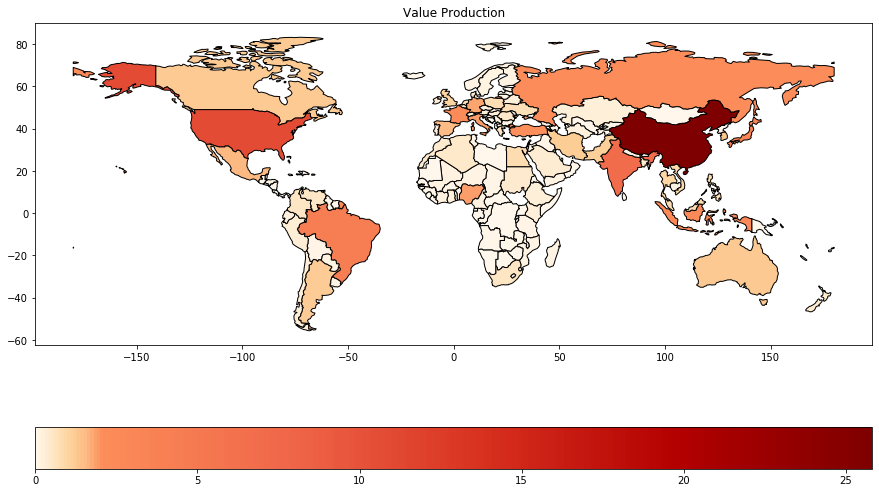

In [57]:
# World map
mapp(value_production.Recent,'Value Production')

In [58]:
# Save to pickle
value_production.to_pickle("pickle/value_production.pkl")

## Interactive Map

In this section, we decide to build interactive maps to show time and space data together in the same visualization.

In [59]:
def interactive_df(df):
    df = df.drop(['World'])
    df = df.drop(['Recent'], axis=1)
    df = df.apply(norm)*100
    df.columns = df.columns.str.replace('Y', '')
    df = df.stack()
    df = df.reset_index()
    df = df.rename(columns={'level_1': 'Year', 0: 'Total'})
    df['Year'] = df['Year'].astype(int)
    return df

In [60]:
def mapp_interactive(result, world_df=world_df):
    year = np.mean(result['Year'])
    result = result.drop('Year', axis=1)
    merged = world_df.set_index('name').join(result)
    merged = merged.dropna(subset=['Total'])
    vmin, vmax, vcenter = merged.Total.min(), merged.Total.max(), merged.Total.quantile(0.9)
    divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)
    ax = merged.plot(column='Total', figsize=(15,10), k=9, norm=divnorm, cmap='Greens', linewidth=1, edgecolor = "black",
                     legend=True, legend_kwds={'orientation': "horizontal"})
    ax.set_title(year,size=10)
    return

In [61]:
def plot_func(year):
    result = df
    result = result.set_index('Area')
    result = result[result['Year']==year]
    mapp_interactive(result)

### Crops Production interactive

In [62]:
interactive_crops = interactive_df(crops_production_total)
interactive_crops.head()

,Area,Year,Total
0,China,1961,15.441609
1,China,1962,15.727734
2,China,1963,15.506055
3,China,1964,15.279008
4,China,1965,16.785257


In [63]:
df = interactive_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### Live Stock interactive

In [64]:
interactive_livestock = interactive_df(livestock_total)

In [65]:
df = interactive_livestock
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

### Production value interactive

In [66]:
interactive_value_production = interactive_df(value_production)

In [67]:
df = interactive_value_production
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2003, description='year', max=2016, min=1991), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

# International Trade

In [68]:
# Load dataset
trade = pd.read_csv('datasets/'+TRADE, encoding = "ISO-8859-1")
trade.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,231,Almonds shelled,5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,167.0,181.0,845.0,102.0
1,2,Afghanistan,231,Almonds shelled,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1116.0,1377.0,4988.0,758.0
2,2,Afghanistan,231,Almonds shelled,5910,Export Quantity,tonnes,0.0,0.0,0.0,...,2917.0,4763.0,1308.0,2262.0,1125.0,2381.0,2716.0,2342.0,1691.0,3335.0
3,2,Afghanistan,231,Almonds shelled,5922,Export Value,1000 US$,0.0,0.0,0.0,...,14784.0,35476.0,15893.0,20270.0,9647.0,18617.0,16453.0,17808.0,11954.0,23248.0
4,2,Afghanistan,711,"Anise, badian, fennel, coriander",5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,284.0,1000.0,815.0,38.0


In the `trade` dataset, we have import and export quantities and values for a number of different `Item` i.e. vegetables and fruits. We focus on the value only, and divide the data into two dataframe, `trade_import` and `trade_export`.

In [69]:
trade_import = trade[trade.Element=='Import Value']
trade_import.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1,2,Afghanistan,231,Almonds shelled,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1116.0,1377.0,4988.0,758.0
5,2,Afghanistan,711,"Anise, badian, fennel, coriander",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,599.0,2041.0,1669.0,97.0
9,2,Afghanistan,515,Apples,5622,Import Value,1000 US$,0.0,0.0,0.0,...,131.0,553.0,9743.0,990.0,500.0,166.0,20129.0,800.0,31173.0,88287.0
13,2,Afghanistan,526,Apricots,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
17,2,Afghanistan,527,"Apricots, dry",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2.0,40.0,9.0


In [70]:
trade_export = trade[trade.Element=='Export Value']
trade_export.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
3,2,Afghanistan,231,Almonds shelled,5922,Export Value,1000 US$,0.0,0.0,0.0,...,14784.0,35476.0,15893.0,20270.0,9647.0,18617.0,16453.0,17808.0,11954.0,23248.0
7,2,Afghanistan,711,"Anise, badian, fennel, coriander",5922,Export Value,1000 US$,NaN,NaN,NaN,...,1843.0,6888.0,8771.0,4428.0,4511.0,8133.0,70841.0,37709.0,26898.0,16002.0
11,2,Afghanistan,515,Apples,5922,Export Value,1000 US$,0.0,0.0,0.0,...,3664.0,4683.0,719.0,1201.0,7689.0,10387.0,4750.0,15918.0,25788.0,15087.0
15,2,Afghanistan,526,Apricots,5922,Export Value,1000 US$,0.0,0.0,0.0,...,3330.0,10915.0,2455.0,1793.0,1584.0,3678.0,5885.0,4437.0,6536.0,7069.0
19,2,Afghanistan,527,"Apricots, dry",5922,Export Value,1000 US$,0.0,0.0,0.0,...,9671.0,6331.0,9982.0,8193.0,9357.0,16365.0,11092.0,11403.0,6454.0,20664.0


In this case, by inspecting the `Item` column, we can detect the most important aggregate values we could use for our analysis. We decide to divide the data into the usual two groups: crops and livestock. To be consistent with the `value_production` dataset, we keep and sum the following items to build the two datasets:

For `_crops` dataset:
* 1944: `Cereals`
* 1889: `Fruit and Vegetables`
* 1899, 1903, 1905: `Oil`

For `_livestock` dataset:
* 1886: `Diary Products + Eggs`
* 2077: `Total Meat`

In [71]:
item_code_crops = [1944, 1889, 1899, 1903, 1905]
item_code_livestock = [1886, 2077]

In [72]:
trade_import_crops = trade_import.loc[trade_import['Item Code'].map(lambda x: x in item_code_crops),]
trade_import_livestock = trade_import.loc[trade_import['Item Code'].map(lambda x: x in item_code_livestock),]
trade_export_crops = trade_export.loc[trade_export['Item Code'].map(lambda x: x in item_code_crops),]
trade_export_livestock = trade_export.loc[trade_export['Item Code'].map(lambda x: x in item_code_livestock),]

In [73]:
trade_import_crops.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1004,2,Afghanistan,1903,Animal Vegetable Oil,5622,Import Value,1000 US$,109.0,103.0,134.0,...,271175.0,170676.0,322981.0,349989.0,597053.0,632205.0,412117.0,337357.0,368116.0,377297.0
1036,2,Afghanistan,1944,Cereals,5622,Import Value,1000 US$,4200.0,880.0,7350.0,...,833776.0,519102.0,297322.0,488484.0,337177.0,350869.0,607525.0,678780.0,785532.0,806735.0
1066,2,Afghanistan,1905,Fixed Vegetable Oils,5622,Import Value,1000 US$,109.0,103.0,134.0,...,139073.0,127965.0,203674.0,180718.0,207272.0,216745.0,279970.0,270095.0,305768.0,323907.0
1079,2,Afghanistan,1889,Fruit and Vegetables,5622,Import Value,1000 US$,2.0,1.0,4.0,...,18993.0,75961.0,149357.0,229567.0,244293.0,259591.0,589618.0,310170.0,519648.0,610305.0
1142,2,Afghanistan,1899,Oilseeds,5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,13372.0,8107.0,26273.0,27117.0


In [74]:
# define time window
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

In [75]:
# Clean dataset
trade_import_crops = clean_df(trade_import_crops,years,to_drop,changes)
trade_import_crops.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,653011.0,620765.0,708217.0,783039.0,753024.0,741114.0,698211.0,693078.0,636080.0,814951.0,...,46778430.0,57819329.0,70485073.0,85252959.0,85330904.0,87681593.0,82919228.0,76001160.0,85552159.0,10.306402
United States of America,550358.0,541466.0,605865.0,715561.0,770739.0,882791.0,830040.0,1018555.0,992374.0,1108110.0,...,30978933.0,34454571.0,42351294.0,40136267.0,46390199.0,45183126.0,48468934.0,50992296.0,54690966.0,7.658046
Germany,1865629.0,2197966.0,1964179.0,2237538.0,2575781.0,2661983.0,2579265.0,2556397.0,2869403.0,3409830.0,...,29194433.0,30225395.0,38192522.0,36027716.0,38138682.0,37629411.0,34541803.0,35014289.0,36917641.0,6.806067
Japan,604755.0,665716.0,873175.0,1098263.0,1322539.0,1449933.0,1519365.0,1527807.0,1588155.0,1978804.0,...,18648435.0,20557716.0,25879413.0,25432103.0,24467759.0,22247979.0,20575338.0,19544792.0,20206183.0,4.898681
Netherlands,461079.0,499260.0,538057.0,555959.0,632598.0,638811.0,666294.0,729985.0,865533.0,1023332.0,...,20439582.0,21856460.0,28179562.0,29395927.0,30790018.0,28000188.0,24504238.0,25679895.0,31926016.0,4.674137


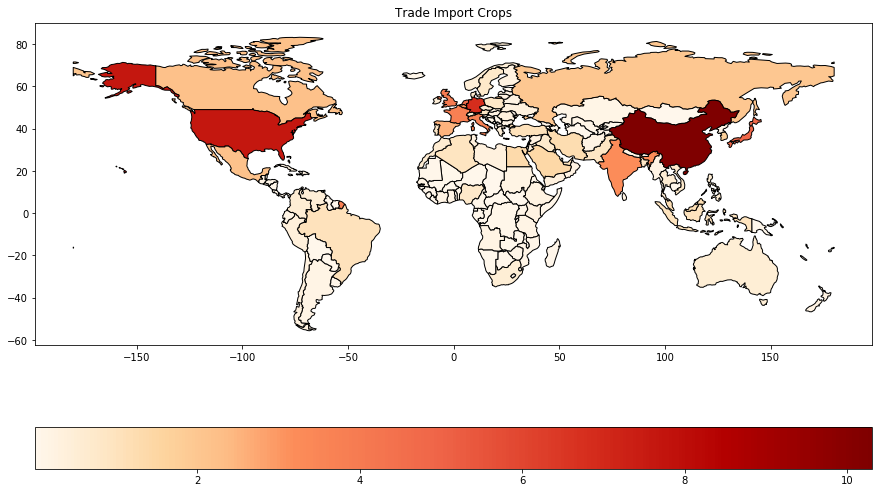

In [76]:
# World map
mapp(trade_import_crops.Recent,'Trade Import Crops')

In [77]:
# Interactive map
interactive_trade_import_crops = interactive_df(trade_import_crops)

In [78]:
df = interactive_trade_import_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [79]:
trade_import_livestock = clean_df(trade_import_livestock,years,to_drop,changes)
interactive_trade_import_livestock = interactive_df(trade_import_livestock)

In [80]:
# Clean dataset
trade_export_crops = clean_df(trade_export_crops,years,to_drop,changes)
trade_export_crops.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
United States of America,3163874.0,3487312.0,3789497.0,4339904.0,4498790.0,4974040.0,4429132.0,4132554.0,3936864.0,5131329.0,...,56043272.0,65523159.0,75896241.0,76607315.0,73782563.0,78421120.0,68609046.0,72323816.0,71707207.0,13.793369
Spain,385407.0,378119.0,344894.0,458417.0,368812.0,467685.0,549979.0,479163.0,540695.0,758005.0,...,20403972.0,22190664.0,24704875.0,25612523.0,27650694.0,29629443.0,26537701.0,28490800.0,31092569.0,5.459615
Malaysia,98006.0,92663.0,94636.0,94709.0,120619.0,128452.0,124174.0,147605.0,147593.0,241008.0,...,22826671.0,31113211.0,43807649.0,37791847.0,30905097.0,30860981.0,24769800.0,24498746.0,26377864.0,5.411377
Indonesia,84370.0,58161.0,63417.0,84122.0,81761.0,96734.0,79851.0,97016.0,81620.0,126973.0,...,24794962.0,33042847.0,43108586.0,42930247.0,37890481.0,43247378.0,38621851.0,37519893.0,47166010.0,5.369886
Netherlands,312474.0,383278.0,390459.0,401217.0,478715.0,456954.0,507891.0,588668.0,718321.0,848104.0,...,23661026.0,24272083.0,28437595.0,28127912.0,29962496.0,25874797.0,23492802.0,26094908.0,32440671.0,5.150867


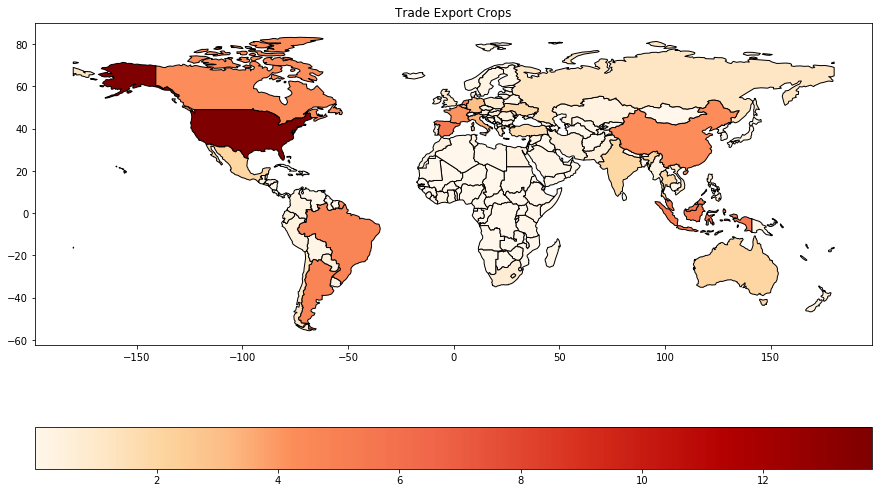

In [81]:
# World map
mapp(trade_export_crops.Recent,'Trade Export Crops')

In [82]:
# Interactive map
interactive_trade_export_crops = interactive_df(trade_export_crops)

In [83]:
df = interactive_trade_export_crops
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [84]:
trade_export_livestock = clean_df(trade_export_livestock,years,to_drop,changes)
interactive_trade_export_livestock = interactive_df(trade_export_livestock)

In [85]:
# Save to pickle format
trade_import_crops.to_pickle("pickle/trade_import_crops.pkl")
trade_export_crops.to_pickle("pickle/trade_export_crops.pkl")
trade_import_livestock.to_pickle("pickle/trade_import_livestock.pkl")
trade_export_livestock.to_pickle("pickle/trade_export_livestock.pkl")

## Trade Matrix

In [86]:
# Load dataset
tradem = pd.read_csv('datasets/'+TRADE_MATRIX, encoding = "ISO-8859-1")
tradem.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
1,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
2,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5.0
3,2,Afghanistan,4,Algeria,561,Raisins,5910,Export Quantity,tonnes,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,NaN,NaN,NaN
4,2,Afghanistan,4,Algeria,561,Raisins,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN


In [87]:
# Select import values
tradem_import = tradem[tradem.Element=='Import Value']
tradem_import.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
10,2,Afghanistan,9,Argentina,1232,Food prep nes,5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN
12,2,Afghanistan,9,Argentina,56,Maize,5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,68.0
14,2,Afghanistan,9,Argentina,1058,"Meat, chicken",5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,281.0,NaN,NaN,1163.0,159.0,1653.0,1761.0
16,2,Afghanistan,9,Argentina,897,"Milk, whole dried",5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,191.0,NaN
18,2,Afghanistan,9,Argentina,164,Sugar refined,5622,Import Value,1000 US$,NaN,...,NaN,NaN,NaN,130.0,NaN,NaN,NaN,NaN,NaN,NaN


In [88]:
# Select export values
tradem_export = tradem[tradem.Element=='Export Value']
tradem_export.head()

,Reporter Country Code,Reporter Countries,Partner Country Code,Partner Countries,Item Code,Item,Element Code,Element,Unit,Y1986,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
1,2,Afghanistan,4,Algeria,230,"Cashew nuts, shelled",5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN
2,2,Afghanistan,4,Algeria,1293,Crude materials,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,5.0
4,2,Afghanistan,4,Algeria,561,Raisins,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN
6,2,Afghanistan,4,Algeria,723,Spices nes,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
8,2,Afghanistan,7,Angola,1232,Food prep nes,5922,Export Value,1000 US$,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN


In [89]:
# Define time window and columns to drop
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Reporter Country Code','Partner Country Code','Item Code','Element Code']

In [90]:
def cleanm_df(df, to_drop, changes):
    df = df.set_index('Partner Countries').rename(columns={'Reporter Countries':'Area'})
    df = df.replace(changes).replace({'Area':{'China, mainland':'China'}})
    df = df.rename(columns={'Area':'Reporter'})
    df = df.reset_index().set_index('Reporter').rename(columns={'Partner Countries':'Area'})
    df = df.replace(changes).replace({'Area':{'China, mainland':'China'}})
    df = df.rename(columns={'Area':'Partner'})
    df = df.groupby(['Reporter','Partner']).sum().reset_index()
    df = df.drop(to_drop, axis=1)
    df = df.loc[df.Reporter.map(lambda x: x in countries),:]
    df = df.loc[df.Partner.map(lambda x: x in countries),:]
    df = df.set_index(['Reporter','Partner'])
    return df[years]

In [91]:
# Clean datasets
tradem_import = cleanm_df(tradem_import,to_drop,changes)
tradem_export = cleanm_df(tradem_export,to_drop,changes)

We decide to take, for each pair, trade values data in recent years. Moreover, to provide a meaningful representation of data, we rename index columns as `From` and `To`: these names better describe the actual goods flow.

In [92]:
# Take recent years
tradem_import = tradem_import[years]
tradem_export = tradem_export[years]

In [93]:
# Rename index columns
tradem_import = tradem_import.reset_index().rename(columns={'Reporter':'To','Partner':'From'}).set_index(['From','To'])
tradem_export = tradem_export.reset_index().rename(columns={'Reporter':'From','Partner':'To'}).set_index(['From','To'])

In [94]:
# Build a unique dataset
trade_matrix = tradem_import.join(tradem_export,lsuffix='I',rsuffix='E')

In [95]:
# Check length
len(trade_matrix)

20105

Let's try to reduce the number of pairs, eliminating those which involve little trading value:

In [96]:
# Rank trades (pairs) by average trade value in recent years
trade_matrix.mean(axis=1).sort_values(ascending=False).head()

From                      To                      
Canada                    United States of America    1.674693e+07
Netherlands               Germany                     1.655842e+07
United States of America  Canada                      1.540618e+07
                          Mexico                      1.370132e+07
                          China                       1.351586e+07
dtype: float64

We could state that a reasonable choice could be to take into account only trades which involve at least 1M USD on average in recent years

In [97]:
# Meaningful trades
tradem_import = tradem_import[tradem_import.mean(axis=1)>1000]
tradem_export = tradem_export[tradem_export.mean(axis=1)>1000]

In [98]:
# Keep only pairs in both dataset
pairs = set(tradem_import.index).intersection(tradem_export.index)
tradem_import = tradem_import.loc[tradem_import.index.map(lambda x: x in pairs),:]
tradem_export = tradem_export.loc[tradem_export.index.map(lambda x: x in pairs),:]

In [99]:
# Build a unique dataset
trade_matrix = tradem_import.join(tradem_export,lsuffix='I',rsuffix='E')

In [100]:
# Check length
len(trade_matrix)

6513

The number of trades recorded in the dataset has thus been cutted down to 1/3.

We now check for the consistency into the dataset: indeed, reported export from e.g. Italy to France should be roughly equal to reported import to France from Italy. We check for that by looking at the average reported trade values in recent years, and computing the ratio between the values in the two different datasets.

In [101]:
# Compute ratio in different datasets
ratio = tradem_import.mean(axis=1)/tradem_export.mean(axis=1)

In [102]:
# Check for inconsistencies
len(ratio[ratio>1.2])+len(ratio[ratio<0.8])

3755

Unfortunately, some relevant inconsistencies are present (about half of the pairs do not fit in the 20% tolerance range). Unfortunately, there is no simple way to fix this issue, so we decide to build a unique matrix by taking the mean of the two trades values provided.

In [103]:
# Unique dataset
trade_matrix = 0.5*tradem_import+0.5*tradem_export
trade_matrix.head()

Y2000   Y2001   Y2002    Y2003    Y2004    Y2005  \
From        To                                                             
Afghanistan China      2681.5    61.0    40.0    296.0    446.0    678.5   
            Germany      14.0   100.5    19.5    163.5    116.5    356.5   
            India     12650.5  9130.0  8667.5  16268.0  17634.0  25144.0   
            Iran        461.0    58.5    56.5    372.5   1214.0   1737.5   
            Pakistan  12589.5  8157.0  8323.5  10849.0  13144.5   6061.0   

                        Y2006    Y2007    Y2008    Y2009    Y2010    Y2011  \
From        To                                                               
Afghanistan China        16.0    899.0   1135.0   2193.5   6480.5   3625.0   
            Germany     447.5   2241.5    817.0   2024.5   9492.5   4409.5   
            India      9447.0  39789.0  56214.0  86308.0  69985.5  77918.0   
            Iran          0.0      0.0      0.0  16581.5  20263.5   8197.0   
            Pakistan  11909.5  24175.5  21790.0  85256.5  80580.0  66835.5   

                        Y2012    Y2013     Y2014     Y2015     Y2016     Y2017  
From        To                                                                  
Afghanistan China      1423.5   3871.0   13894.5    5270.0     519.5     248.0  
            Germany    1254.5   2839.0    8431.5    3577.5    2955.0    5227.0  
            India     20342.0  86445.0  165823.5  232559.0  198471.5  293335.5  
            Iran          0.0      0.0   13000.0       0.0   16493.5   10589.0  
            Pakistan  59615.5  94408.0  160601.0  250839.5  219945.5  229055.0

In [104]:
# Save pickle file
trade_matrix.to_pickle("pickle/trade_matrix.pkl")

# Emissions
In this section we analyze the total emissions in agriculture dataset from [FAO](http://www.fao.org/faostat/en/#data/GT).

In [105]:
# Import the dataset
emissions = pd.read_csv('datasets/'+EMISSIONS,encoding = "ISO-8859-1")

In [106]:
# See how it is organized
print(emissions.columns)
emissions.head()

Index(['Area Code', 'Area', 'Item Code', 'Item', 'Element Code', 'Element',
       'Unit', 'Y1961', 'Y1962', 'Y1963', 'Y1964', 'Y1965', 'Y1966', 'Y1967',
       'Y1968', 'Y1969', 'Y1970', 'Y1971', 'Y1972', 'Y1973', 'Y1974', 'Y1975',
       'Y1976', 'Y1977', 'Y1978', 'Y1979', 'Y1980', 'Y1981', 'Y1982', 'Y1983',
       'Y1984', 'Y1985', 'Y1986', 'Y1987', 'Y1988', 'Y1989', 'Y1990', 'Y1991',
       'Y1992', 'Y1993', 'Y1994', 'Y1995', 'Y1996', 'Y1997', 'Y1998', 'Y1999',
       'Y2000', 'Y2001', 'Y2002', 'Y2003', 'Y2004', 'Y2005', 'Y2006', 'Y2007',
       'Y2008', 'Y2009', 'Y2010', 'Y2011', 'Y2012', 'Y2013', 'Y2014', 'Y2015',
       'Y2016', 'Y2017', 'Y2030', 'Y2050'],
      dtype='object')


,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2030,Y2050
0,2,Afghanistan,5058,Enteric Fermentation,7225,Emissions (CH4),gigagrams,240.6831,245.3106,255.8285,...,401.0680,402.5130,396.9210,393.0930,398.2870,384.1370,381.6789,371.9253,453.7474,603.6185
1,2,Afghanistan,5058,Enteric Fermentation,7231,Emissions (CO2eq),gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
2,2,Afghanistan,5058,Enteric Fermentation,7244,Emissions (CO2eq) from CH4,gigagrams,5054.3459,5151.5228,5372.3989,...,8422.4280,8452.7730,8335.3410,8254.9530,8364.0270,8066.8761,8015.2578,7810.4313,9528.6962,12675.9880
3,2,Afghanistan,5059,Manure Management,7225,Emissions (CH4),gigagrams,11.6228,11.9632,12.6064,...,26.5669,26.1599,26.0913,26.0859,26.3682,24.9017,24.7679,23.7619,27.2114,35.2700
4,2,Afghanistan,5059,Manure Management,7231,Emissions (CO2eq),gigagrams,367.8310,376.4362,392.5811,...,681.2759,678.8488,672.3300,667.6991,675.6191,645.1936,641.9611,623.3735,750.3240,1003.2279


In [107]:
# See the unique values of the interesting columns
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())
uniquevalues(emissions)

Item
['Enteric Fermentation' 'Manure Management' 'Rice Cultivation'
 'Synthetic Fertilizers' 'Manure applied to Soils'
 'Manure left on Pasture' 'Crop Residues' 'Burning - Crop residues'
 'Burning - Savanna' 'Agriculture total' 'Agricultural Soils'
 'Cultivation of Organic Soils']
Element
['Emissions (CH4)' 'Emissions (CO2eq)' 'Emissions (CO2eq) from CH4'
 'Emissions (CO2eq) from N2O' 'Emissions (N2O)']
Unit
['gigagrams']


As we can see from the `Element` column, we have different emissions measurements. Among all we have the column `Emissions (CO2eq)` that is actually the sum of all the emissions converted into equivalent CO2 production. Therefore we decide to keep only these values.

In [108]:
# Keep only the CO2 equivalent values
emissions = emissions[emissions.Element=='Emissions (CO2eq)']

Considering the `Item` column, we can see that the emission production can be referred to different specific agriculture topics. We notice that we could specifically refer them to livestock or crop production. Therefore we decide to split the dataset into two different datasets.

The dataset `emissions_livestock` contains the emissions referred to:
* 'Enteric Fermentation'
* 'Manure Management'
* 'Manure left on Pature'

The dataset `emissions_crops` contains the emissions referred to:
* 'Synthetic Fertilizers'
* 'Manure applied to Soils'
* 'Crop Residues'
* 'Burning - Crop residues'
* 'Burning - Savanna'
* 'Rice Cultivation'
* 'Cultivation of Organic Soils'

In [109]:
# Create the livestock emissions dataset
emissions_livestock = emissions[(emissions.Item=='Enteric Fermentation')\
                     | (emissions.Item=='Manure Management')\
                     | (emissions.Item=='Manure left on Pasture')]

In [110]:
# Create the crops emissions dataset
emissions_crops = emissions[(emissions.Item=='Synthetic Fertilizers')\
                     | (emissions.Item=='Manure applied to Soils')\
                     | (emissions.Item=='Crop Residues')\
                     | (emissions.Item=='Burning - Crop residues')\
                     | (emissions.Item=='Burning - Savanna')\
                     | (emissions.Item=='Rice Cultivation')\
                     | (emissions.Item=='Cultivation of Organic Soils')]

For this dataset we also have predictions for the emissions in 2030 and 2050: we decide to keep them as they might be useful for further analyses.

In [111]:
# Define time window and columns to drop
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']

We then use the previously defined function `clean_df` that we use to clean the datasets.

In [112]:
# Clean crops dataset
emissions_crops = clean_df(emissions_crops,years,to_drop,changes)

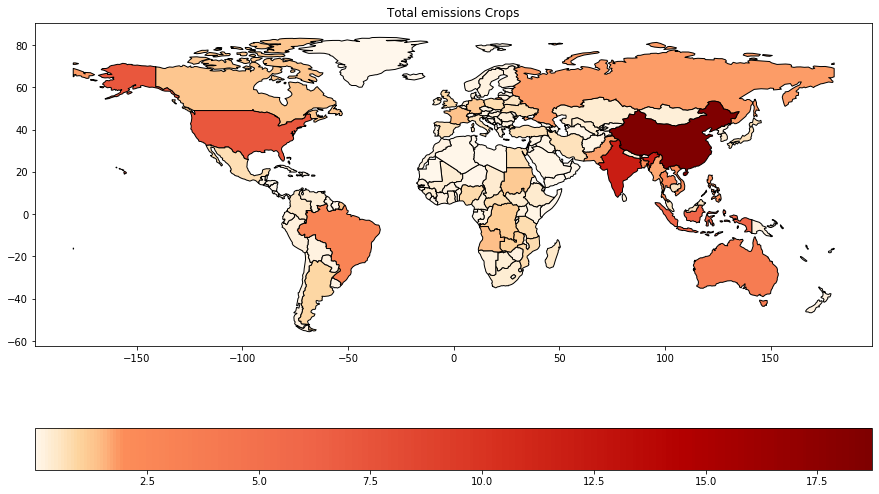

In [113]:
# World map
mapp(emissions_crops.Recent,'Total emissions Crops')

In [114]:
# Crops interactive map
interactive_emissions_crops = interactive_df(emissions_crops)

In [115]:
df = interactive_emissions_crops
range_year = (df['Year'].min(),2017)
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [116]:
# Clean livestock dataset
emissions_livestock = clean_df(emissions_livestock,years,to_drop,changes)

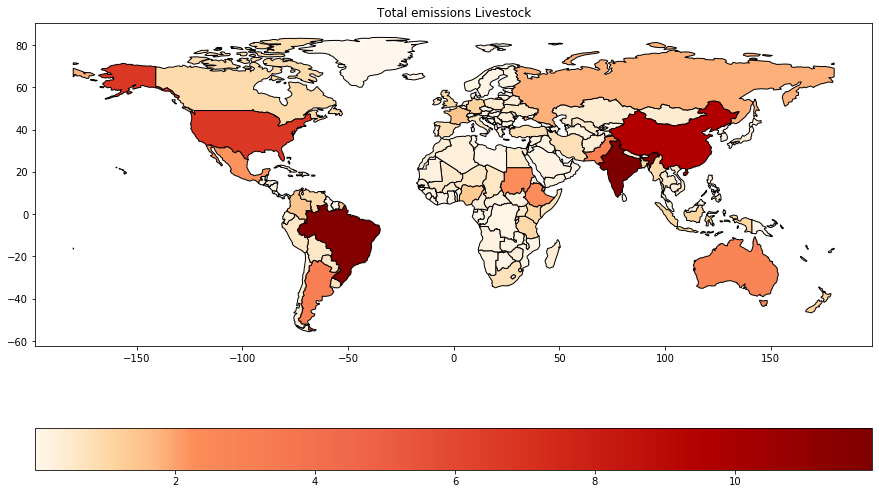

In [117]:
# World map
mapp(emissions_livestock.Recent,'Total emissions Livestock')

In [118]:
# Livestock interactive map
interactive_emissions_livestock = interactive_df(emissions_livestock)

In [119]:
df = interactive_emissions_livestock
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2005, description='year', max=2050, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [120]:
# Save datasets to pickle
emissions_livestock.to_pickle("pickle/emissions_livestock.pkl")
emissions_crops.to_pickle("pickle/emissions_crops.pkl")

# Fertilizers
We now consider the fertilizers use datasets. For this topic we do not have a unique dataset but we actually consider three different ones since FAO in 2002 changed the way they collected the data. Until 2002 they had a unique dataset called `fertilizers archive`, then they changed the classification methods and decided to have three different datasets:
* `fertilizers by nutrient` containing information on the totals separately for the three main plant nutrients nitrogen (N), phosphate (P2O5) and potash (K2O);
* `fertilizers by product` containing information on fertilizing products amounts;
* `fertilizers indicators` containing the use of fertilizers per area of cropland grouped into the three main plant nutrients.

In order to provide a unique dataset we have to go further in understanding how the data is organized. So let's import them and have a look.

In [121]:
# Import the datasets
fert_a = pd.read_csv('datasets/'+FERT_A, encoding = "ISO-8859-1")
fert_n = pd.read_csv('datasets/'+FERT_N, encoding = "ISO-8859-1")
fert_p = pd.read_csv('datasets/'+FERT_P, encoding = "ISO-8859-1")
fert_i = pd.read_csv('datasets/'+FERT_I, encoding = "ISO-8859-1")

In [122]:
fert_a.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1961F,Y1962,...,Y1998,Y1998F,Y1999,Y1999F,Y2000,Y2000F,Y2001,Y2001F,Y2002,Y2002F
0,2,Afghanistan,1402,Ammonia,5510,Production,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
1,2,Afghanistan,1402,Ammonia,5610,Import Quantity,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
2,2,Afghanistan,1402,Ammonia,5910,Export Quantity,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
3,2,Afghanistan,1402,Ammonia,5157,Agricultural Use,tonnes,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR
4,2,Afghanistan,1402,Ammonia,5751,Prices Paid by Farmers,LCU/mt,0.0,NR,0.0,...,0.0,NR,0.0,NR,0.0,NR,0.0,NR,0.0,NR


In [123]:
fert_p.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,4007,"Ammonia, anhydrous",5610,Import Quantity,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,4.49,NaN,NaN,2.00,NaN,NaN,2.07
1,2,Afghanistan,4007,"Ammonia, anhydrous",5622,Import Value,1000 US$,NaN,NaN,NaN,...,NaN,NaN,NaN,2.69,NaN,NaN,1.07,NaN,NaN,1.24
2,2,Afghanistan,4003,Ammonium nitrate (AN),5610,Import Quantity,tonnes,1786.13,NaN,NaN,...,NaN,NaN,NaN,NaN,1456.8,1.0,NaN,NaN,NaN,NaN
3,2,Afghanistan,4003,Ammonium nitrate (AN),5622,Import Value,1000 US$,123.24,NaN,NaN,...,NaN,NaN,NaN,NaN,445.8,2.8,NaN,NaN,NaN,NaN
4,2,Afghanistan,4002,Ammonium sulphate,5610,Import Quantity,tonnes,NaN,0.14,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23.0,NaN


In [124]:
fert_n.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5510,Production,tonnes,23414.00,16206.00,19458.00,...,15324.00,13606.00,12022.00,17555.00,15776.00,15694.00,14416.00,14416.00,14416.00,14416.00
1,2,Afghanistan,3102,Nutrient nitrogen N (total),5610,Import Quantity,tonnes,1132.46,4233.77,2905.48,...,4.68,1001.89,914.39,5411.94,1289.25,19223.36,59482.34,6659.57,82277.39,126363.30
2,2,Afghanistan,3102,Nutrient nitrogen N (total),5910,Export Quantity,tonnes,22.93,32.75,23.79,...,896.65,452.01,7.38,0.00,0.00,13.57,27.14,0.00,22.55,5.14
3,2,Afghanistan,3102,Nutrient nitrogen N (total),5157,Agricultural Use,tonnes,24523.53,20407.02,22339.69,...,14432.03,14155.88,12929.01,22970.63,17065.25,34903.79,73872.84,21075.57,96670.85,140775.85
4,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5510,Production,tonnes,0.00,0.00,NaN,...,NaN,NaN,NaN,1563.00,460.00,1539.00,1541.00,1541.00,1541.00,1541.00


In [125]:
fert_i.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2002,Y2003,Y2004,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,kg/ha,3.16,2.58,2.82,...,1.82,1.79,1.63,2.90,2.16,4.41,9.34,2.66,12.22,17.80
1,2,Afghanistan,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,kg/ha,0.00,0.84,1.36,...,0.00,0.07,0.12,0.87,0.16,0.38,0.65,1.28,1.14,2.11
2,2,Afghanistan,3104,Nutrient potash K2O (total),5159,Use per area of cropland,kg/ha,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.02,0.01,0.00,0.00,0.01,0.00
3,3,Albania,3102,Nutrient nitrogen N (total),5159,Use per area of cropland,kg/ha,54.67,53.47,51.67,...,41.24,48.76,44.96,53.01,50.21,44.11,44.13,52.87,60.98,56.70
4,3,Albania,3103,Nutrient phosphate P2O5 (total),5159,Use per area of cropland,kg/ha,26.02,28.65,31.94,...,25.81,29.96,31.08,33.54,31.85,32.90,32.91,41.27,49.10,30.77


In [126]:
def uniquevalues(df):
    for i in ['Item', 'Element', 'Unit']:
        print(i)
        print(df[i].unique())

In [127]:
uniquevalues(fert_a)

Item
['Ammonia' 'Ammonium nitrate (AN)' 'Ammonium Phosphat (P2o5)'
 'Ammonium Phosphate (N)' 'Ammonium sulphate' 'Ammonium SulphateNitrate'
 'Basic Slag' 'Calcium ammonium nitrate' 'Calcium Cyanamide'
 'Calcium Nitrate' 'Complex Fertilizer (K2o)' 'Concent Superphosphate'
 'Crude Salts To 20% K2o' 'Ground Rock Phosphate' 'Muriate 20-45% K2o'
 'Muriate Over 45% K2o' 'Nitrogenous fertilizers'
 'Oth Complex Fert (P2o5)' 'Other Complex Fert (N)'
 'Other nitrogenous fertilizers, n.e.c.'
 'Other phosphatic fertilizers, n.e.c.\r\n'
 'Other potassic fertilizers, n.e.c.' 'Phosphate fertilizers'
 'Potash fertilizers' 'Potassium sulphate (sulphate of potash) (SOP)'
 'Single Superphosphate' 'Sodium Nitrate' 'Urea' 'Total Fertilizers'
 'Phosphoric Acid']
Element
['Production' 'Import Quantity' 'Export Quantity' 'Agricultural Use'
 'Prices Paid by Farmers']
Unit
['tonnes' 'LCU/mt']


As previously said, for the first three dasets we are going to select only the element `Agricultural Use`. Since in the dataset `fertilizers indicators` we only have the amount of fertilizer used per cropland, we are initially not going to consider this dataset. We may will consider it later if it will be needed. 

In [128]:
# Select agricultural use Element
fert_a = fert_a[fert_a.Element=='Agricultural Use']
fert_p = fert_p[fert_p.Element=='Agricultural Use']
fert_n = fert_n[fert_n.Element=='Agricultural Use']

In [129]:
# Check Unit
fert_a.Unit.unique(), fert_p.Unit.unique(), fert_n.Unit.unique()

(array(['tonnes'], dtype=object),
 array(['tonnes'], dtype=object),
 array(['tonnes'], dtype=object))

In [130]:
# Get the total sum from a by nutrient categorization on fertilizers archive
fert_a_n = fert_a[(fert_a.Item=='Nitrogenous fertilizers')\
          | (fert_a.Item=='Phosphate fertilizers')\
          | (fert_a.Item=='Potash fertilizers')]\
          .groupby('Area').sum()
fert_a_n.Y2002.head()

Area
Afghanistan       20800.0
Africa          4278401.0
Albania           35357.0
Algeria           98000.0
Americas       35142135.0
Name: Y2002, dtype: float64

In [131]:
# Get the total sum from a by product categorization on fertilizers archive
fert_a_p = fert_a[(fert_a.Item!='Nitrogenous fertilizers')\
          & (fert_a.Item!='Phosphate fertilizers')\
          & (fert_a.Item!='Potash fertilizers')\
          & (fert_a.Item!='Total Fertilizers') ]\
          .groupby(['Area']).sum()
fert_a_p.Y2002.head()

Area
Afghanistan         20800.0
Africa            3567481.0
Albania             35357.0
Algeria                 0.0
American Samoa          0.0
Name: Y2002, dtype: float64

As we can see we now found how the dataset `fertilizers archive` categorizes the data. It seems that we could obtain the same total amount of fertilizer used from the two methods (by nutrient or by product) but still information is lacking from the categorization by product. From the `fertilizers archive` dataset we therefore decide to keep only the total amount of fertilizers used yearly for each country by keeping only the items `Total Fertilizers`.

Concerning the `fertilizers by nutrient` dataset we read from the [FAO website](http://fenixservices.fao.org/faostat/static/documents/RFN/RFN_EN_README.pdf) that the nutrients are calculated by also taking into account the compound fertilizers that, however, are not considered in the `fertilizers archive`.
This explains why we obtain results that are close but still different from the two totals of the two datasets.

Since in our analysis we are now interested in percentages rather than precise values of fertilizers use, from now on we are going to consider the `fertilizers by nutrient` for the years from 2002 on and the `Total Fertilizers` items from the `fertilizeers archive` for years before 2002.

We are now goint to put them together but first we need to drop the `Flag` columns (that say how data was calculated) from the `fertilizers archive`.

In [132]:
# Drop the flag years and the year 2002 from fertilizers archive
years_drop = ['Y'+str(1900+x)+'F' for x in range(61,100)] + ['Y'+str(2000+x)+'F' for x in range(0,3)]+['Y2002']
fert_a = fert_a.drop(years_drop, axis=1)

In [133]:
# Filter only the Total Fertilizers items
fert_a = fert_a[fert_a.Item=='Total Fertilizers']
fert_a = fert_a.replace(changes)
fert_a.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,Y2000,Y2001
143,2,Afghanistan,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1100.0,1100.0,1100.0,...,45800.0,40000.0,0.0,0.0,5000.0,5000.0,7000.0,5000.0,5000.0,18400.0
293,3,Albania,1818,Total Fertilizers,5157,Agricultural Use,tonnes,6302.0,5200.0,5300.0,...,23500.0,17890.0,14770.0,11000.0,6500.0,5200.0,25000.0,10600.0,18700.0,18700.0
443,4,Algeria,1818,Total Fertilizers,5157,Agricultural Use,tonnes,49000.0,55000.0,53000.0,...,96800.0,130900.0,119300.0,46400.0,38000.0,97000.0,108000.0,93000.0,92300.0,105300.0
603,7,Angola,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1000.0,1000.0,1400.0,...,9100.0,8000.0,10000.0,8000.0,6000.0,2000.0,3400.0,3400.0,1400.0,0.0
758,9,Argentina,1818,Total Fertilizers,5157,Agricultural Use,tonnes,16241.0,12711.0,21080.0,...,248200.0,293900.0,462000.0,524700.0,855200.0,809600.0,775500.0,823500.0,862983.0,861991.0


In [134]:
# Calculate the total use on the fertilizers by nutrient dataset
fert_n = fert_n.replace(changes)
fert_n = fert_n.groupby(['Area']).sum().drop(['Area Code','Item Code','Element Code'], axis=1)
fert_n.head()

,Y2002,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,
Afghanistan,24526.53,27035.26,33169.37,29774.39,24869.52,16377.29,14432.03,14712.11,13854.86,29816.20,18523.47,38011.93,79000.86,31232.39,105733.85,157464.02
Africa,4117961.79,4526013.11,4694822.50,4502916.67,4395095.09,4422820.77,5042626.73,4391993.97,5507875.99,5234137.06,5442198.67,5565927.83,5962381.02,5670156.19,5942546.50,6503404.15
Albania,56404.00,57406.71,58555.64,60457.92,50108.64,51106.74,47158.94,55040.42,53224.98,60604.12,57614.41,54410.38,54410.30,66327.00,78243.70,61082.86
Algeria,72765.00,45031.00,188038.00,55806.00,99072.00,111748.00,64231.00,107000.00,118500.00,118300.00,160100.00,168300.00,190500.00,175600.00,155700.00,155700.00
Americas,35120342.52,38073447.14,40713476.39,37527532.77,38521459.24,42447632.31,38469890.76,33291895.38,39107790.21,44887837.66,45047835.97,47188778.26,47690069.87,44500444.18,47394970.46,50227671.05


In [135]:
# Create a unique dataset
fertilizers = fert_a.set_index('Area').join(fert_n)

In [136]:
fertilizers.head()

,Area Code,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,Y1964,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,2,1818,Total Fertilizers,5157,Agricultural Use,tonnes,1100.0,1100.0,1100.0,1100.0,...,14432.03,14712.11,13854.86,29816.20,18523.47,38011.93,79000.86,31232.39,105733.85,157464.02
Africa,5100,1818,Total Fertilizers,5157,Agricultural Use,tonnes,716141.0,780262.0,879628.0,996966.0,...,5042626.73,4391993.97,5507875.99,5234137.06,5442198.67,5565927.83,5962381.02,5670156.19,5942546.50,6503404.15
Albania,3,1818,Total Fertilizers,5157,Agricultural Use,tonnes,6302.0,5200.0,5300.0,6400.0,...,47158.94,55040.42,53224.98,60604.12,57614.41,54410.38,54410.30,66327.00,78243.70,61082.86
Algeria,4,1818,Total Fertilizers,5157,Agricultural Use,tonnes,49000.0,55000.0,53000.0,52500.0,...,64231.00,107000.00,118500.00,118300.00,160100.00,168300.00,190500.00,175600.00,155700.00,155700.00
Americas,5200,1818,Total Fertilizers,5157,Agricultural Use,tonnes,9027226.0,10161226.0,11335980.0,11908846.0,...,38469890.76,33291895.38,39107790.21,44887837.66,45047835.97,47188778.26,47690069.87,44500444.18,47394970.46,50227671.05


In [137]:
# Define time window
years = ['Y'+str(2000+x) for x in range(0,17)]

We then use the previously defined function `clean_df` that we use to clean the datasets.

In [138]:
# Clean dataset
fertilizers = clean_df(fertilizers,years,to_drop,changes)
fertilizers.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,728000.0,989600.0,1247000.0,1677000.0,2604000.0,3719000.0,2697000.0,2696000.0,3474000.0,4407000.0,...,47015712.03,51511621.90,53182047.83,54078095.65,53779194.72,55618943.32,54558935.73,53724192.41,52995366.31,28.248659
India,338300.0,452200.0,543900.0,773200.0,784600.0,1100600.0,1539000.0,1760700.0,1982000.0,2256600.0,...,26445526.00,28110244.00,28373686.00,25536100.00,24482500.00,25581400.00,26752600.00,25949900.00,26593400.00,13.567807
United States of America,7646496.0,8604260.0,9474315.0,9953907.0,11276278.0,12676548.0,13645012.0,14074587.0,14577261.0,15535480.0,...,17137601.00,18262765.00,20070761.00,20565302.10,20994055.00,20660881.00,20211336.00,20544035.00,20459267.00,11.992508
Brazil,270004.0,256082.0,297782.0,247651.0,278878.0,276059.0,447925.0,601709.0,630384.0,1001917.0,...,7540435.57,10424767.72,13081009.13,12116475.02,14147326.89,15363337.57,12809826.43,14523279.55,16582859.11,6.310013
Indonesia,135990.0,149396.0,130000.0,96242.0,94498.0,145004.0,126700.0,271408.0,178007.0,240193.0,...,4286696.00,4283793.00,4662837.00,5203810.20,5159718.30,5460675.20,5443037.13,5444238.66,5824967.75,2.391433


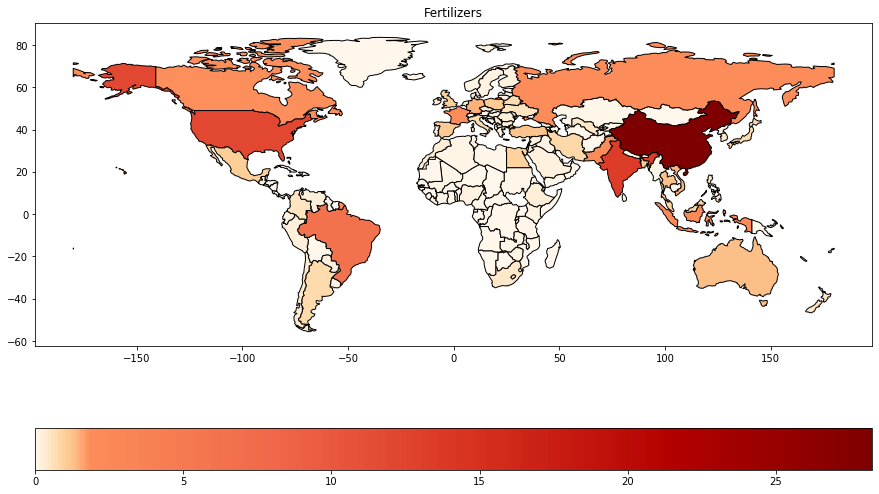

In [139]:
# World map
mapp(fertilizers.Recent,'Fertilizers')

In [140]:
# Interactive map
interactive_fertilizers = interactive_df(fertilizers)

In [141]:
df = interactive_fertilizers
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [142]:
# Save to pickle
fertilizers.to_pickle("pickle/fertilizers.pkl")

# Pesticides

In [143]:
# Load dataset
pesticides = pd.read_csv('datasets/'+PESTICIDES, encoding = "ISO-8859-1")
pesticides.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1990,Y1991,Y1992,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,3,Albania,1357,Pesticides (total),5157,Agricultural Use,tonnes,121.0,121.0,121.0,...,392.6,403.49,582.93,574.62,353.05,441.53,447.89,590.41,656.52,681.14
1,3,Albania,1309,Insecticides,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,213.88,375.80,317.07,157.57,214.13,34.48,184.59,226.30,237.59
2,3,Albania,1310,Insecticides  Chlorinated Hydrocarbons,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,Albania,1311,Insecticides  Organo-phosphates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3,Albania,1312,Insecticides  Carbamates,5157,Agricultural Use,tonnes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


To have a general idea on the use of pesticides, we focus on the their total amount.

In [144]:
# Select total amount
pesticides = pesticides[pesticides.Item=='Pesticides (total)']

In [145]:
# Clean dataset
years = ['Y'+str(2000+x) for x in range(0,18)]
to_drop = ['Area Code','Item Code','Element Code']
pesticides = clean_df(pesticides,years,to_drop,changes)
pesticides.head()

,Y1990,Y1991,Y1992,Y1993,Y1994,Y1995,Y1996,Y1997,Y1998,Y1999,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,775408.37,775388.37,809244.37,854860.37,988608.37,1097075.37,1150843.77,1204908.17,1240708.57,1333139.97,...,1717687.15,1765944.22,1795371.35,1815505.77,1811604.85,1815732.79,1772420.36,1772588.89,1773634.40,43.678972
United States of America,400975.93,384646.39,400975.90,391903.86,425922.68,423201.53,433180.36,434540.76,424562.11,433633.96,...,358337.70,374818.20,391298.70,407779.20,407779.20,407779.20,407779.20,407779.20,407779.20,11.072901
Brazil,49695.00,58349.44,67003.89,75658.33,84312.78,92967.22,101621.67,110276.11,118930.56,127585.00,...,335742.00,342580.00,345026.00,346583.00,367778.00,352336.00,395646.00,377176.00,377176.00,7.618887
Argentina,26156.00,26156.00,26156.00,26156.00,30195.00,37842.00,54595.00,77691.00,62397.00,73152.15,...,138831.47,234430.38,219255.93,215405.95,211555.98,207706.00,203806.98,199907.95,196008.93,4.483995
France,97701.00,103434.00,85249.00,91953.00,89515.00,84011.00,97890.00,109793.00,107754.00,114696.00,...,63692.00,61911.00,61039.00,63547.59,66497.29,74909.60,66531.02,71951.22,70588.70,2.069175


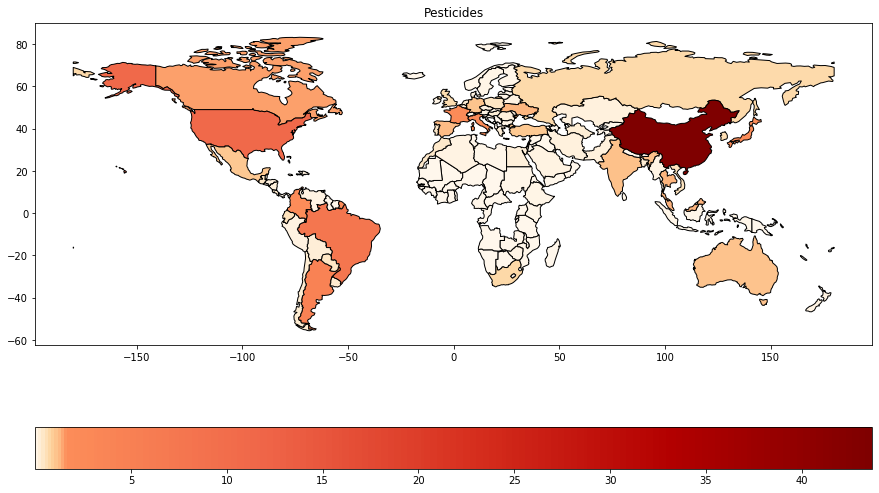

In [146]:
# World map
mapp(pesticides.Recent,'Pesticides')

In [147]:
# Interactive map
interactive_pesticides = interactive_df(pesticides)

In [148]:
df = interactive_pesticides
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=2003, description='year', max=2017, min=1990), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [149]:
pesticides.to_pickle("pickle/pesticides.pkl")

# Land Use

In [150]:
# Load dataset
land_use = pd.read_csv('datasets/'+LAND, encoding='latin-1')
land_use.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2008,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017
0,2,Afghanistan,6600,Country area,5110,Area,1000 ha,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
1,2,Afghanistan,6601,Land area,5110,Area,1000 ha,65286.0,65286.0,65286.0,...,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0,65286.0
2,2,Afghanistan,6602,Agriculture,5110,Area,1000 ha,37700.0,37760.0,37810.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
3,2,Afghanistan,6610,Agricultural land,5110,Area,1000 ha,37700.0,37760.0,37810.0,...,37910.0,37910.0,37911.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0,37910.0
4,2,Afghanistan,6620,Cropland,5110,Area,1000 ha,7700.0,7760.0,7810.0,...,7910.0,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0


In [151]:
land_use['Element'].value_counts()

Area                              5558
Carbon stock in living biomass     271
Name: Element, dtype: int64

We consider only the `Area` element of the dataset.

In [152]:
land_use = land_use[land_use.Element=='Area']

In [153]:
# Check unit
land_use['Unit'].value_counts()

1000 ha    5558
Name: Unit, dtype: int64

In [154]:
# Have a look at which Items do we have in the dataset
items = land_use[['Area','Item Code','Item']].groupby(['Item Code','Item']).count()
items[items.Area > 50].sort_values('Item Code').head(10)

,,Area
Item Code,Item,
6600,Country area,272
6601,Land area,272
6602,Agriculture,270
6610,Agricultural land,270
6611,Agriculture area actually irrigated,113
6620,Cropland,267
6621,Arable land,263
6630,Land under temporary crops,99
6633,Land under temp. meadows and pastures,56


In [155]:
item_code_list = set([6600, 6601, 6680, 6610, 6620, 6630, 6650, 6621, 6633, 6655, 6646, 6714, 6716, 6717])

In [156]:
changes_item = {'Item' : {'Land under permanent crops' : 'Crops' ,
                    'Land under temporary crops' : 'Crops',
                    'Land under perm. meadows and pastures' : 'Meadows',
                    'Land under temp. meadows and pastures' : 'Meadows',
                    'Other naturally regenerated forest' : 'Other forest'
                    }}

In [157]:
land_use = land_use.replace(changes_item)

In [158]:
to_drop = ['Area Code','Item Code','Element Code']
land_use = clean_df_items(land_use,item_code_list,to_drop,changes)
land_use

Y1961    Y1962    Y1963    Y1964    Y1965  \
Area        Item                                                             
Afghanistan Agricultural land  37700.0  37760.0  37810.0  37873.0  37875.0   
            Arable land         7650.0   7700.0   7750.0   7800.0   7800.0   
            Country area       65286.0  65286.0  65286.0  65286.0  65286.0   
            Cropland            7700.0   7760.0   7810.0   7873.0   7875.0   
            Crops                 50.0     60.0     60.0     73.0     75.0   
...                                ...      ...      ...      ...      ...   
eSwatini    Land area           1720.0   1720.0   1720.0   1720.0   1720.0   
            Meadows             1342.0   1342.0   1342.0   1342.0   1342.0   
            Other forest           0.0      0.0      0.0      0.0      0.0   
            Planted Forest         0.0      0.0      0.0      0.0      0.0   
            Primary Forest         0.0      0.0      0.0      0.0      0.0   

                                 Y1966    Y1967    Y1968    Y1969    Y1970  \
Area        Item                                                             
Afghanistan Agricultural land  37913.0  37979.0  37980.0  37996.0  38006.0   
            Arable land         7835.0   7844.0   7844.0   7860.0   7870.0   
            Country area       65286.0  65286.0  65286.0  65286.0  65286.0   
            Cropland            7913.0   7979.0   7980.0   7996.0   8006.0   
            Crops                 78.0    135.0    136.0    136.0    136.0   
...                                ...      ...      ...      ...      ...   
eSwatini    Land area           1720.0   1720.0   1720.0   1720.0   1720.0   
            Meadows             1342.0   1342.0   1342.0   1342.0   1342.0   
            Other forest           0.0      0.0      0.0      0.0      0.0   
            Planted Forest         0.0      0.0      0.0      0.0      0.0   
            Primary Forest         0.0      0.0      0.0      0.0      0.0   

                               ...    Y2008    Y2009    Y2010    Y2011  \
Area        Item               ...                                       
Afghanistan Agricultural land  ...  37910.0  37910.0  37911.0  37910.0   
            Arable land        ...   7794.0   7793.0   7793.0   7791.0   
            Country area       ...  65286.0  65286.0  65286.0  65286.0   
            Cropland           ...   7910.0   7910.0   7911.0   7910.0   
            Crops              ...   3340.0   3586.0   3599.0   3200.0   
...                            ...      ...      ...      ...      ...   
eSwatini    Land area          ...   1720.0   1720.0   1720.0   1720.0   
            Meadows            ...   1032.0   1032.0   1032.0   1032.0   
            Other forest       ...    412.2    417.6    423.0    428.6   
            Planted Forest     ...    142.0    141.0    140.0    139.0   
            Primary Forest     ...      0.0      0.0      0.0      0.0   

                                 Y2012    Y2013    Y2014    Y2015    Y2016  \
Area        Item                                                             
Afghanistan Agricultural land  37910.0  37910.0  37910.0  37910.0  37910.0   
            Arable land         7790.0   7785.0   7771.0   7765.0   7729.0   
            Country area       65286.0  65286.0  65286.0  65286.0  65286.0   
            Cropland            7910.0   7910.0   7910.0   7910.0   7910.0   
            Crops               3574.0   3616.0   3624.0   3500.0   3600.0   
...                                ...      ...      ...      ...      ...   
eSwatini    Land area           1720.0   1720.0   1720.0   1720.0   1720.0   
            Meadows             1032.0   1032.0   1032.0   1032.0   1032.0   
            Other forest         434.2    439.8    445.4    451.0    451.0   
            Planted Forest       138.0    137.0    136.0    135.0    135.0   
            Primary Forest         0.0      0.0      0.0      0.0      0.0   

                         

For future analysis on crops production, we save the `Cropland` data separately from the rest.

In [159]:
# Define time windows on recent years
years = ['Y'+str(2000+x) for x in range(0,18)]

In [160]:
# Clean dataset
cropland = land_use.reset_index()
cropland = cropland[cropland.Item=='Cropland'].drop(columns=['Item']).set_index('Area')
sumCol = cropland.sum().rename("World")
cropland['Recent'] = cropland[years].apply(norm).mean(axis=1)*100
cropland = cropland.append(sumCol)
cropland.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,7700.0,7760.0,7810.0,7873.0,7875.0,7913.0,7979.0,7980.0,7996.0,8006.0,...,7910.0,7911.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0,7910.0000,0.521939
Albania,479.0,487.0,495.0,501.0,522.0,540.0,556.0,570.0,585.0,599.0,...,696.0,696.0,696.0,696.0,696.3,696.0,696.1,703.5,691.1000,0.046054
Algeria,7066.0,6900.0,6810.0,6753.0,6784.0,6784.0,6866.0,6787.0,6787.0,6800.0,...,8399.0,8411.0,8421.0,8430.5,8435.2,8439.2,8462.4,8417.6,8483.4261,0.553601
Angola,3170.0,3200.0,3220.0,3250.0,3270.0,3300.0,3330.0,3360.0,3400.0,3400.0,...,4290.0,4390.0,4990.0,4990.0,5190.0,5190.0,5190.0,5195.0,5215.0000,0.280176
Argentina,19472.0,20061.0,20486.0,20892.0,21358.0,22511.0,23249.0,24765.0,26816.0,26925.0,...,35292.0,38981.0,39781.0,40754.0,40699.0,40200.0,40200.0,40200.0,40200.0000,2.377722


We now build a different dataset, taking the average on recent years.

In [161]:
# Take mean on recent years
land_use_pivot = land_use.reset_index().set_index(['Area','Item'])[years].mean(axis = 1)

In [162]:
# Create summary dataset
land_use_pivot = land_use_pivot.unstack(level='Item')
land_use_pivot.head()

Item,Agricultural land,Arable land,Country area,Cropland,Crops,Forest land,Inland waters,Land area,Meadows,Other forest,Planted Forest,Primary Forest
Area,,,,,,,,,,,,
Afghanistan,37883.944444,7763.055556,65286.0,7883.944444,3181.111111,1350.000000,NaN,65286.0,30000.000000,1350.000000,0.000000,0.0
Albania,1158.592833,597.283333,2875.0,695.611111,211.916667,775.494444,118.033333,2740.0,577.031722,596.238889,94.455556,84.8
Algeria,41030.173611,7501.883728,238174.0,8362.890339,4774.228183,1765.944444,NaN,238174.0,32667.291100,1312.888889,453.055556,0.0
Angola,58242.777778,3950.000000,124670.0,4242.777778,292.777778,58688.000000,NaN,124670.0,54000.000000,58559.000000,129.000000,0.0
Argentina,141725.388889,34969.944444,278040.0,35969.944444,26355.333333,29169.444444,4371.000000,273669.0,109622.500000,26262.666667,1168.777778,1738.0


In [163]:
# Define summary dataset
land_use_general = land_use_pivot[['Country area','Land area']]
land_use_general['Cropland'] = land_use_pivot['Cropland']/land_use_pivot['Land area']*100
land_use_general['Meadows'] = land_use_pivot['Meadows']/land_use_pivot['Land area']*100
land_use_general['Forestry'] = land_use_pivot['Forest land']/land_use_pivot['Land area']*100

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Claudio\Anaconda3\envs\ada\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

In [164]:
land_use_general.head(10)

Item,Country area,Land area,Cropland,Meadows,Forestry
Area,,,,,
Afghanistan,65286.0,65286.000000,12.076011,45.951659,2.067825
Albania,2875.0,2740.000000,25.387267,21.059552,28.302717
Algeria,238174.0,238174.000000,3.511252,13.715725,0.741451
Angola,124670.0,124670.000000,3.403207,43.314350,47.074677
Argentina,278040.0,273669.000000,13.143595,40.056601,10.658659
Armenia,2974.0,2847.000000,17.618156,39.185888,11.657495
Australia,774122.0,768338.000000,3.583001,48.134664,16.374000
Austria,8387.9,8256.127778,17.370256,18.338820,46.708741
Azerbaijan,8660.0,8264.527778,25.634590,31.967075,11.925061


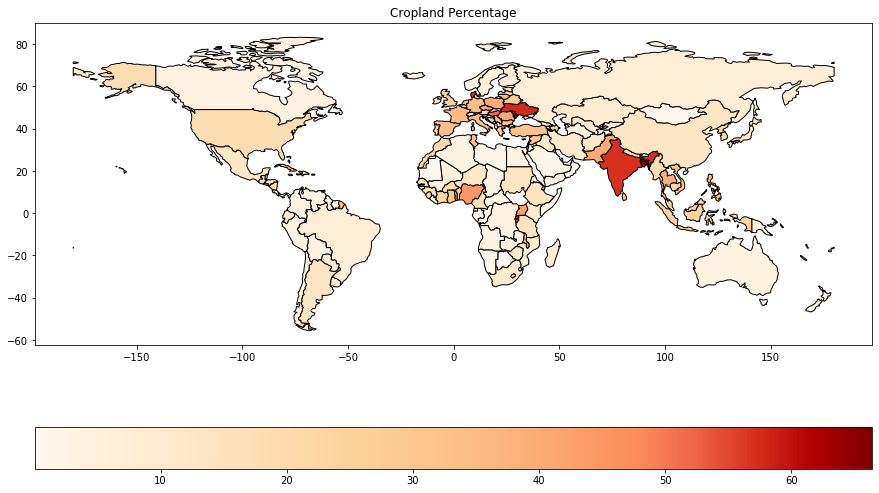

In [165]:
# World map
mapp(land_use_general.Cropland,'Cropland Percentage')

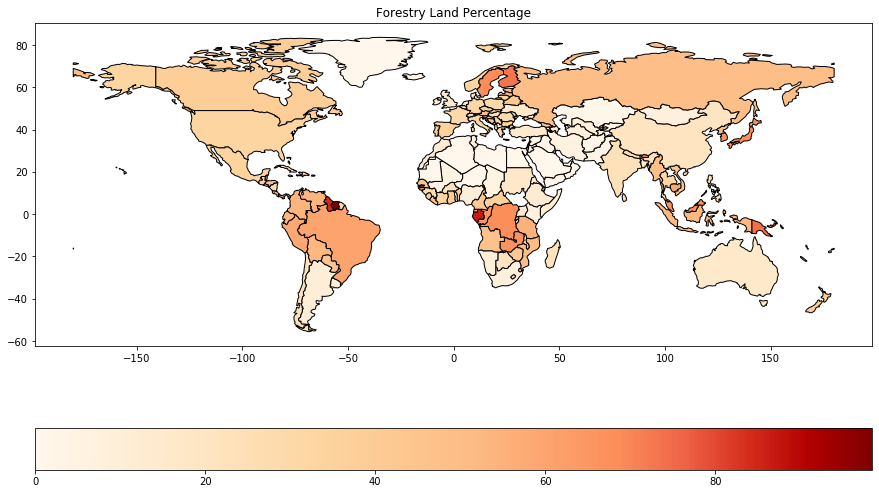

In [166]:
# World map
mapp(land_use_general.Forestry,'Forestry Land Percentage')

In [167]:
# Cropland interactive map
interactive_cropland = interactive_df(cropland)

In [168]:
df = interactive_cropland
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2017, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [169]:
# Save data to pickle
land_use.to_pickle("pickle/land_use.pkl")
land_use_general.to_pickle("pickle/land_use_general.pkl")
cropland.to_pickle("pickle/cropland.pkl")

## Soil Quality

In [170]:
# Load dataset
soil = pd.read_csv('datasets/'+SOIL, encoding='latin-1')
soil.head()

,CountryCode,Country,ItemCode,Item,ElementGroup,ElementCode,Element,Year,Unit,Value,Flag
0,2,Afghanistan,6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.22,NaN
1,2,Afghanistan,6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,2.64,NaN
2,2,Afghanistan,6709,Soil,7221,7221,Average carbon content in the topsoil as a % i...,2008,%,0.92,NaN
3,5100,Africa + (Total),6709,Soil,7219,7219,Average soil erosion expressed in GLASOD erosi...,1991,degrees,0.89,A
4,5100,Africa + (Total),6709,Soil,7220,7220,Average land degradation in GLASOD erosion degree,1991,degrees,2.10,A


In [171]:
soil.Element.value_counts()

Average carbon content in the topsoil as a % in weight     235
Average land degradation in GLASOD erosion degree          185
Average soil erosion expressed in GLASOD erosion degree    175
Name: Element, dtype: int64

We decide to focus on soil carbon content, which is usually considered among the most reliable indicators of quality of soil.

In [172]:
# Rename Country field for cleaning efficiency
soil = soil.rename(columns={'Country':'Area'})

In [173]:
# Clean dataset on soil carbon content
soil_carbon = soil[soil.ElementCode==7221]
soil_carbon = soil_carbon.drop(columns=['CountryCode','ItemCode','Item','ElementGroup','ElementCode','Element','Unit','Flag'])
soil_carbon = soil_carbon.replace(changes)
soil_carbon = soil_carbon.loc[soil_carbon.Area.map(lambda x: x in countries),:]
soil_carbon = soil_carbon.set_index(['Area'])
soil_carbon.head()

,Year,Value
Area,,
Afghanistan,2008,0.92
Albania,2008,1.24
Algeria,2008,0.81
Angola,2008,0.65
Argentina,2008,1.48


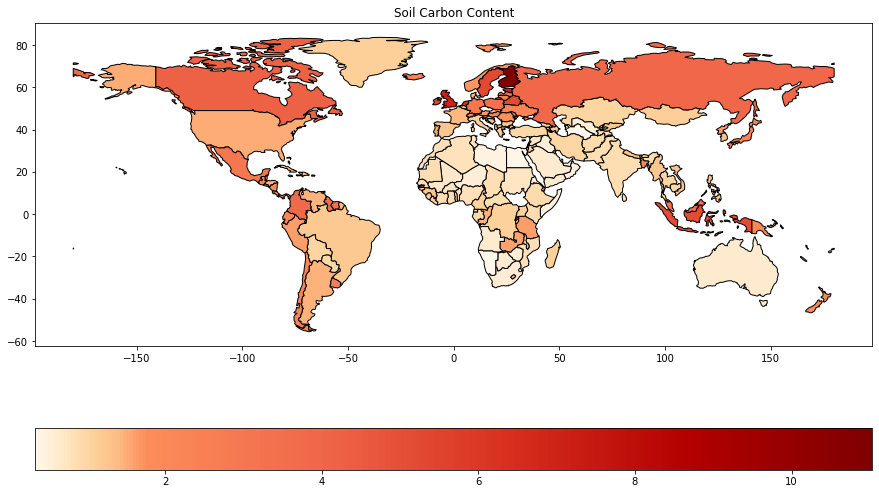

In [174]:
# World map
mapp(soil_carbon.Value,'Soil Carbon Content',quant=0.75)

In [175]:
# Save data to pickle
soil_carbon.to_pickle("pickle/soil_carbon.pkl")

## Energy

In [176]:
# Load dataset
energy = pd.read_csv('datasets/'+ENERGY, encoding='latin-1')
energy.head()

,Country Code,Country,Item Code,Item,Element Code,Element,Year Code,Year,Unit,Value,Flag
0,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1986,1986,Terajoule,288659.0,Fc
1,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1987,1987,Terajoule,313771.0,Fc
2,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1988,1988,Terajoule,329896.0,Fc
3,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1989,1989,Terajoule,355094.0,Fc
4,351,China,6801,Gas-Diesel oil,72184,Consumption in Agriculture,1990,1990,Terajoule,379045.0,Fc


In [177]:
energy['Element'].value_counts()

Consumption in Agriculture             64676
Emissions (CO2eq) (Energy)             59489
Emissions (CO2eq) from N2O (Energy)    59489
Emissions (N2O) (Energy)               59489
Emissions (CH4) (Energy)               59489
Emissions (CO2eq) from CH4 (Energy)    59489
Emissions (CO2) (Energy)               59317
Implied emission factor for N2O        27151
Implied emission factor for CH4        27151
Implied emission factor for CO2        27003
Name: Element, dtype: int64

We will consider only the Element `Consumption in Agriculture`.

In [178]:
# Keep consumption in agriculture data
energy = energy[energy.Element=='Consumption in Agriculture']

In [179]:
energy['Item'].value_counts()

Electricity                                           10374
Transport fuel used in agriculture (excl. fishery)     7370
Energy used in fishery                                 6857
Fuel oil used in fisheries                             6786
Gas-diesel oils used in fisheries                      6778
Total Energy                                           6151
Gas-Diesel oil                                         4756
Energy for power irrigation                            4054
Fuel oil                                               3064
Motor Gasoline                                         2694
Liquefied petroleum gas (LPG)                          2486
Natural gas (including LNG)                            1909
Coal                                                   1397
Name: Item, dtype: int64

In [180]:
# Columns to drop
energy = energy.drop(columns=['Country Code','Element','Element Code','Year Code','Flag'])

In [181]:
energy.groupby(['Item','Unit']).count()

Country  \
Item                                               Unit                   
Coal                                               Terajoule       1397   
Electricity                                        Terajoule       5187   
                                                   million kWh     5187   
Energy for power irrigation                        Terajoule       4054   
Energy used in fishery                             Terajoule       6857   
Fuel oil                                           Terajoule       3064   
Fuel oil used in fisheries                         Terajoule       6786   
Gas-Diesel oil                                     Terajoule       4756   
Gas-diesel oils used in fisheries                  Terajoule       6778   
Liquefied petroleum gas (LPG)                      Terajoule       2486   
Motor Gasoline                                     Terajoule       2694   
Natural gas (including LNG)                        Terajoule       1909   
Total Energy                                       Terajoule       6151   
Transport fuel used in agriculture (excl. fishery) Terajoule       7370   

                                                                Item Code  \
Item                                               Unit                     
Coal                                               Terajoule         1397   
Electricity                                        Terajoule         5187   
                                                   million kWh       5187   
Energy for power irrigation                        Terajoule         4054   
Energy used in fishery                             Terajoule         6857   
Fuel oil                                           Terajoule         3064   
Fuel oil used in fisheries                         Terajoule         6786   
Gas-Diesel oil                                     Terajoule         4756   
Gas-diesel oils used in fisheries                  Terajoule         6778   
Liquefied petroleum gas (LPG)                      Terajoule         2486   
Motor Gasoline                                     Terajoule         2694   
Natural gas (including LNG)                        Terajoule         1909   
Total Energy                                       Terajoule         6151   
Transport fuel used in agriculture (excl. fishery) Terajoule         7370   

                                                                Year  Value  
Item                                               Unit                      
Coal                                               Terajoule    1397   1397  
Electricity                                        Terajoule    5187   5187  
                                                   million kWh  5187   5187  
Energy for power irrigation                        Terajoule    4054   4054  
Energy used in fishery                             Terajoule    6857   6857  
Fuel oil                                           Terajoule    3064   3064  
Fuel oil used in fisheries                         Terajoule    6786   6786  
Gas-Diesel oil                                     Terajoule    4756   4756  
Gas-diesel oils used in fisheries                  Terajoule    6778   6778  
Liquefied petroleum gas (LPG)                      Terajoule    2486   2486  
Motor Gasoline                                     Terajoule    2694   2694  
Natural gas (including LNG)                        Terajoule    1909   1909  
Total Energy                                       Terajoule    6151   6151  
Transport fuel used in agriculture (excl. fishery) Terajoule    7370   7370

In [182]:
# Select only data reported in Terajoule
energy = energy[energy.Unit=='Terajoule']
energy = energy.drop(columns=['Unit'])

In [183]:
# Clean dataset
energy = energy.replace(changes)
energy = energy.loc[energy.Country.map(lambda x: x in countries),:]
energy.head()

,Country,Item Code,Item,Year,Value
0,China,6801,Gas-Diesel oil,1986,288659.0
1,China,6801,Gas-Diesel oil,1987,313771.0
2,China,6801,Gas-Diesel oil,1988,329896.0
3,China,6801,Gas-Diesel oil,1989,355094.0
4,China,6801,Gas-Diesel oil,1990,379045.0


As a first analysis, we consider only total energy consumed and keep these data in a separate DataFrame, which will be useful later on.

In [184]:
# Create summary dataset
energy_total = energy[energy.Item=='Total Energy']
energy_total = energy_total.rename(columns={'Country':'Area'}).set_index(['Area','Year'])
energy_total = energy_total.drop(columns=['Item Code','Item']).unstack()
energy_total.columns = ['Y'+str(1900+x) for x in range(70,100)] + ['Y'+str(2000+x) for x in range(0,13)]
energy_total.head()

,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,...,Y2003,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,43.2,46.8,57.6,57.6,68.4,75.6,75.6,86.4,93.6,97.2,...,54.0,72.0,72.0,216.0,360.0,360.0,360.0,360.0,360.0,360.0
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1062.8,3093.2,2813.2,5414.8,2874.2,2860.0,2763.2,2598.4,3250.6,2892.2
Algeria,NaN,NaN,NaN,111.6,115.2,129.6,133.2,154.8,190.8,198.0,...,0.0,540.0,558.0,0.0,0.0,0.0,4462.8,6224.1,6672.6,6967.8
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,172.0,86.0,86.0,172.0,172.0,258.0,301.0,344.0,344.0,387.0
Argentina,34142.0,34486.0,35217.0,NaN,NaN,NaN,75035.0,77400.0,66478.0,94385.0,...,116328.4,139146.2,195114.0,140917.8,124911.8,175298.1,167766.8,144754.1,122029.0,126720.9


In [185]:
# Define time window
years = ['Y'+str(2000+x) for x in range(0,13)]

In [186]:
# Compute world total and share in recent years
sumCol = energy_total.sum().rename("World")
energy_total['Recent'] = energy_total[years].apply(norm).mean(axis=1)*100
energy_total = energy_total.append(sumCol)
energy_total.head()

,Y1970,Y1971,Y1972,Y1973,Y1974,Y1975,Y1976,Y1977,Y1978,Y1979,...,Y2004,Y2005,Y2006,Y2007,Y2008,Y2009,Y2010,Y2011,Y2012,Recent
Area,,,,,,,,,,,,,,,,,,,,,
Afghanistan,43.2,46.8,57.6,57.6,68.4,75.6,75.6,86.4,93.6,97.2,...,72.0,72.0,216.0,360.0,360.0,360.0,360.0,360.0,360.0,0.003363
Albania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3093.2,2813.2,5414.8,2874.2,2860.0,2763.2,2598.4,3250.6,2892.2,0.051541
Algeria,NaN,NaN,NaN,111.6,115.2,129.6,133.2,154.8,190.8,198.0,...,540.0,558.0,0.0,0.0,0.0,4462.8,6224.1,6672.6,6967.8,0.033566
Angola,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,86.0,86.0,172.0,172.0,258.0,301.0,344.0,344.0,387.0,0.003130
Argentina,34142.0,34486.0,35217.0,NaN,NaN,NaN,75035.0,77400.0,66478.0,94385.0,...,139146.2,195114.0,140917.8,124911.8,175298.1,167766.8,144754.1,122029.0,126720.9,2.256980


In [187]:
# Energy interactive map
interactive_energy = interactive_df(energy_total)

In [188]:
df = interactive_energy
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1991, description='year', max=2012, min=1970), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [189]:
# Save to pickle
energy.to_pickle("pickle/energy.pkl")
energy_total.to_pickle("pickle/energy_total.pkl")

## Climate Change

In [190]:
# Load dataset
climate_change = pd.read_csv('datasets/'+CLIMATE,encoding = "ISO-8859-1")
climate_change.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
0,2,Afghanistan,7001,January,7271,Temperature change,°C,0.993,0.137,2.441,...,1.764,3.677,1.096,-0.304,2.136,2.422,2.278,3.621,0.279,2.700
1,2,Afghanistan,7001,January,6078,Standard Deviation,°C,1.888,1.888,1.888,...,1.888,1.888,1.888,1.888,1.888,1.888,1.888,1.888,1.888,1.888
2,2,Afghanistan,7002,February,7271,Temperature change,°C,-1.542,2.421,3.849,...,3.025,0.857,1.112,-2.161,0.348,-1.617,3.687,1.713,-0.377,2.652
3,2,Afghanistan,7002,February,6078,Standard Deviation,°C,2.456,2.456,2.456,...,2.456,2.456,2.456,2.456,2.456,2.456,2.456,2.456,2.456,2.456
4,2,Afghanistan,7003,March,7271,Temperature change,°C,0.536,1.444,0.327,...,2.543,4.204,1.837,0.464,-1.072,0.171,-0.133,1.178,0.100,4.214


Among available data, we decide to keep the following values:
* for `Element` column, we focus on `Temperature change` values, which are computed as differences with respect to a specific benchmark temperature;
* for `Months` column, we look at aggregate data, selecting only the field `Meteorogical year`.

In [191]:
# Select interesting data
climate_change = climate_change[climate_change.Element=='Temperature change']
climate_change = climate_change[climate_change.Months=='Meteorological year']
climate_change.head()

,Area Code,Area,Months Code,Months,Element Code,Element,Unit,Y1961,Y1962,Y1963,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
32,2,Afghanistan,7020,Meteorological year,7271,Temperature change,°C,-0.059,-0.154,0.820,...,1.633,1.881,1.787,0.722,1.251,1.299,1.414,1.817,1.716,2.029
66,3,Albania,7020,Meteorological year,7271,Temperature change,°C,0.656,0.318,0.072,...,0.848,0.936,0.701,1.478,1.420,1.157,1.321,1.307,0.990,1.656
100,4,Algeria,7020,Meteorological year,7271,Temperature change,°C,0.378,0.220,0.077,...,0.873,2.151,1.351,1.103,1.181,1.697,1.173,1.862,1.520,1.196
134,5,American Samoa,7020,Meteorological year,7271,Temperature change,°C,-0.085,-0.188,-0.024,...,0.999,NaN,0.582,0.496,0.822,0.819,0.563,1.079,0.988,0.738
168,6,Andorra,7020,Meteorological year,7271,Temperature change,°C,0.691,0.107,-0.719,...,1.443,0.459,1.744,1.357,0.779,1.958,1.547,1.825,1.774,1.822


In [192]:
# Clean dataset
to_drop = ['Area Code','Months Code','Element Code']
climate_change = clean_df(climate_change,years,to_drop,changes)

In [193]:
# Drop useless aggregate data (do not make sense in this case)
climate_change = climate_change.drop('World').drop('Recent',axis=1)
climate_change = climate_change.fillna(0)
climate_change.head()

,Y1961,Y1962,Y1963,Y1964,Y1965,Y1966,Y1967,Y1968,Y1969,Y1970,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Y2018
Area,,,,,,,,,,,,,,,,,,,,,
Greenland,-0.639,0.854,0.468,0.089,1.032,-0.374,-0.350,-0.385,0.124,-0.436,...,0.884,3.030,1.700,1.974,1.135,1.148,0.399,2.419,1.136,1.233
Tunisia,0.184,0.014,-0.254,0.239,-0.236,0.283,-0.033,-0.014,-0.057,-0.164,...,1.274,2.031,1.488,1.859,1.558,1.883,1.548,1.978,1.689,1.463
Qatar,-0.313,0.000,0.038,-0.547,0.175,0.454,-0.458,-0.483,0.511,0.230,...,1.773,2.631,1.917,1.767,1.811,2.014,2.726,2.164,2.428,2.647
Kyrgyzstan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.392,1.694,1.770,0.679,1.770,1.105,1.750,2.150,1.460,1.665
Tajikistan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,...,1.491,1.995,1.755,0.557,1.702,1.237,1.661,2.182,1.312,1.838


In [194]:
# Build interactive plot dataset
interactive_climate_change = climate_change
interactive_climate_change.columns = interactive_climate_change.columns.str.replace('Y', '')
interactive_climate_change = interactive_climate_change.stack()
interactive_climate_change = interactive_climate_change.reset_index()
interactive_climate_change = interactive_climate_change.rename(columns={'level_1': 'Year', 0: 'Total'})
interactive_climate_change['Year'] = interactive_climate_change['Year'].astype(int)

In [195]:
interactive_climate_change.head()

,Area,Year,Total
0,Greenland,1961,-0.639
1,Greenland,1962,0.854
2,Greenland,1963,0.468
3,Greenland,1964,0.089
4,Greenland,1965,1.032


In [196]:
df = interactive_climate_change
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1989, description='year', max=2018, min=1961), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [197]:
# Save to pickle
climate_change.to_pickle("pickle/climate_change.pkl")

## Global Income Inequality

In [198]:
# Load dataset
inequality = pd.read_csv('datasets/'+INEQUALITY,encoding = "ISO-8859-1",sep=';')
inequality.head()

,Percentile,Year,sptinc_z_TW\nPre-tax national income \nTop 10% | share\nTaiwan,sptinc_z_TZ\nPre-tax national income \nTop 10% | share\nTanzania,sptinc_z_TH\nPre-tax national income \nTop 10% | share\nThailand,sptinc_z_TG\nPre-tax national income \nTop 10% | share\nTogo,sptinc_z_TN\nPre-tax national income \nTop 10% | share\nTunisia,sptinc_z_TR\nPre-tax national income \nTop 10% | share\nTurkey,sptinc_z_UG\nPre-tax national income \nTop 10% | share\nUganda,sptinc_z_AE\nPre-tax national income \nTop 10% | share\nUnited Arab Emirates,...,sptinc_z_BA\nPre-tax national income \nTop 10% | share\nBosnia and Herzegovina,sptinc_z_BJ\nPre-tax national income \nTop 10% | share\nBenin,sptinc_z_BE\nPre-tax national income \nTop 10% | share\nBelgium,sptinc_z_BH\nPre-tax national income \nTop 10% | share\nBahrain,sptinc_z_AT\nPre-tax national income \nTop 10% | share\nAustria,sptinc_z_AU\nPre-tax national income \nTop 10% | share\nAustralia,sptinc_z_AL\nPre-tax national income \nTop 10% | share\nAlbania,sptinc_z_DZ\nPre-tax national income \nTop 10% | share\nAlgeria,sptinc_z_AO\nPre-tax national income \nTop 10% | share\nAngola,sptinc_z_AR\nPre-tax national income \nTop 10% | share\nArgentina
0,p90p100,1961,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.2807,NaN,NaN,NaN,NaN
1,p90p100,1962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.2852,NaN,NaN,NaN,NaN
2,p90p100,1963,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.2875,NaN,NaN,NaN,NaN
3,p90p100,1964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.2792,NaN,NaN,NaN,NaN
4,p90p100,1965,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.2769,NaN,NaN,NaN,NaN


In [199]:
# Extract country names from column names
col_names = []
for col in inequality.columns:
    new_col = col.split('\n')[-1]
    col_names = col_names + [new_col]

In [200]:
# Rename columns
inequality.columns = col_names

In [201]:
# Clean dataframe
inequality = inequality.set_index(['Year','Percentile']).stack()
inequality = inequality.unstack('Year').reset_index()
inequality = inequality.replace({'Percentile':{'p0p50':'Poor50','p90p100':'Top10','p99p100':'Top1'}})
inequality.columns = ['Percentile','Area'] + ['Y'+str(1900+x) for x in range(61,100)] + ['Y'+str(2000+x) for x in range(0,18)]

In [202]:
changes_plus = {'Area': { 'Cote dâ\x80\x99Ivoire' : "Côte d'Ivoire",
                          'Czech Republic' : 'Czechia',
                          'DR Congo' : 'Dem. Rep. Congo',
                          'Korea' : 'South Korea',
                          'Swaziland' : 'eSwatini',
                          'USA' : 'United States of America'
                          }}

In [203]:
# Replace changes in countries names
inequality = inequality.replace(changes)
inequality = inequality.replace(changes_plus)
inequality = inequality[inequality.Area.isin(countries)]

In [204]:
# Group data by Country and percentile
inequality = inequality.groupby(['Area','Percentile']).sum()
inequality.head()

Y1961  Y1962  Y1963  Y1964  Y1965  Y1966  Y1967  Y1968  \
Area    Percentile                                                           
Albania Poor50        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        Top1          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        Top10         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
Algeria Poor50        0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
        Top1          0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                    Y1969  Y1970  ...     Y2008     Y2009     Y2010     Y2011  \
Area    Percentile                ...                                           
Albania Poor50        0.0    0.0  ...  0.250300  0.256300  0.264900  0.263100   
        Top1          0.0    0.0  ...  0.075500  0.073200  0.065100  0.065400   
        Top10         0.0    0.0  ...  0.293100  0.288100  0.274400  0.275800   
Algeria Poor50        0.0    0.0  ...  0.199387  0.201947  0.204507  0.207066   
        Top1          0.0    0.0  ...  0.100725  0.099494  0.098264  0.097033   

                       Y2012     Y2013     Y2014     Y2015     Y2016     Y2017  
Area    Percentile                                                              
Albania Poor50      0.264900  0.000000  0.000000  0.000000  0.000000  0.000000  
        Top1        0.064000  0.000000  0.000000  0.000000  0.000000  0.000000  
        Top10       0.274500  0.000000  0.000000  0.000000  0.000000  0.000000  
Algeria Poor50      0.207066  0.207066  0.207066  0.207066  0.207066  0.207066  
        Top1        0.097033  0.097033  0.097033  0.097033  0.097033  0.097033  

[5 rows x 57 columns]

In [205]:
# Save in pickle format
inequality.to_pickle("pickle/inequality.pkl")

In [206]:
# Reformat data
inequality.columns = inequality.columns.str.replace('Y', '')
inequality = inequality.stack().reset_index().rename(columns={'level_2':'Year'})
inequality['Year'] = inequality['Year'].astype(int)
inequality = inequality.set_index(['Area','Year','Percentile']).unstack('Percentile')
inequality.columns = ['Poor50','Top1','Top10']

In [207]:
inequality.head()

Poor50  Top1  Top10
Area    Year                     
Albania 1961     0.0   0.0    0.0
        1962     0.0   0.0    0.0
        1963     0.0   0.0    0.0
        1964     0.0   0.0    0.0
        1965     0.0   0.0    0.0

In [208]:
# Save in pickle format
inequality.to_pickle("pickle/inequality_ref.pkl")

## World Population

In [209]:
# Load dataset
population = pd.read_excel('datasets/'+POPULATION,encoding = "ISO-8859-1")
population.head()

,country,year,rgdpe,rgdpo,pop
0,Aruba,1950,NaN,NaN,NaN
1,Aruba,1951,NaN,NaN,NaN
2,Aruba,1952,NaN,NaN,NaN
3,Aruba,1953,NaN,NaN,NaN
4,Aruba,1954,NaN,NaN,NaN


In [210]:
# Reformat data
population = population[['country','year','pop']].rename(columns={'country':'Area','year':'Year','pop':'Population'})
population = population.set_index(['Area','Year']).unstack()
population.columns = ['Y'+str(1900+x) for x in range(50,100)] + ['Y'+str(2000+x) for x in range(0,18)]
population = population.reset_index()

In [211]:
changes_plus = {'Area' :{ 'Russian Federation' : 'Russia' ,
                          'Czech Republic' : 'Czechia',
                          'D.R. of the Congo' : 'Dem. Rep. Congo',
                          'U.R. of Tanzania: Mainland' : 'Tanzania',
                          "Lao People's DR" : 'Laos',
                          'State of Palestine' : 'Palestine',
                          'United States' : 'United States of America',
                          'ESwatini' : 'eSwatini'
                          }}

In [212]:
# Clean data
years = ['Y'+str(2000+x) for x in range(0,18)]
population = population.replace(changes_plus)
population = clean_df(population,years,[],changes)

In [213]:
population.head()

,Y1950,Y1951,Y1952,Y1953,Y1954,Y1955,Y1956,Y1957,Y1958,Y1959,...,Y2009,Y2010,Y2011,Y2012,Y2013,Y2014,Y2015,Y2016,Y2017,Recent
Area,,,,,,,,,,,,,,,,,,,,,
China,0.000000,0.000000,577.607239,587.313965,597.903748,609.972778,622.445312,636.599182,650.159790,657.847046,...,1352.068115,1359.755127,1367.480225,1375.198608,1382.793213,1390.110352,1397.028564,1403.500366,1409.517456,20.147513
India,369.672852,375.972168,382.576935,389.473053,396.628510,404.041168,411.715973,419.665833,427.889648,436.383331,...,1214.270142,1230.980713,1247.236084,1263.065796,1278.562256,1293.859253,1309.053955,1324.171387,1339.180176,17.913463
United States of America,155.639526,158.304214,161.038376,163.727585,166.632446,169.601715,172.639465,175.788620,178.750732,181.763947,...,306.076355,308.641388,311.051361,313.335419,315.536682,317.718781,319.929169,322.179596,324.459473,4.540574
Indonesia,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,239.340485,242.524124,245.707504,248.883224,252.032257,255.131119,258.162109,261.115448,263.991394,3.545646
Brazil,53.243397,54.790054,56.391075,58.048660,59.765083,61.542740,63.394245,65.306252,67.280891,69.320358,...,194.895996,196.796265,198.686691,200.560989,202.408630,204.213135,205.962112,207.652863,209.288284,2.886031


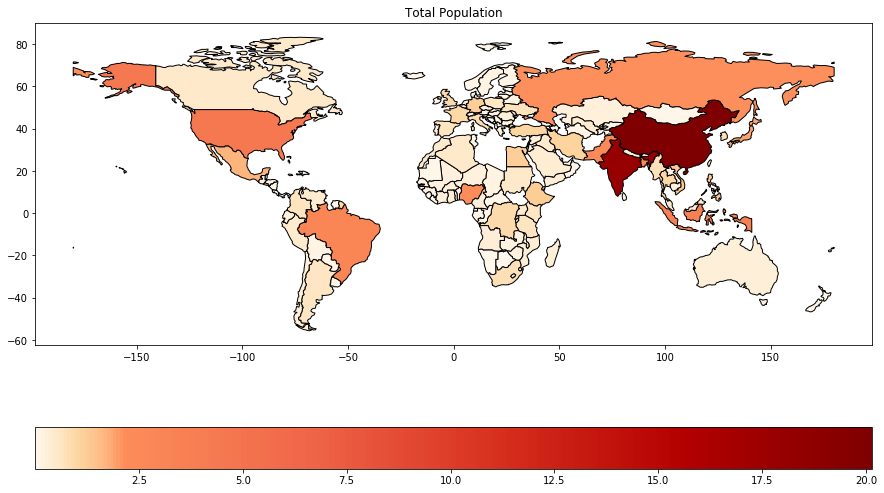

In [214]:
# World map
mapp(population.Recent,'Total Population')

In [215]:
# Interactive map
interactive_population = interactive_df(population)

In [216]:
df = interactive_population
range_year = (df['Year'].min(),df['Year'].max())
interact(plot_func, year = range_year)

interactive(children=(IntSlider(value=1983, description='year', max=2017, min=1950), Output()), _dom_classes=(…

<function __main__.plot_func(year)>

In [217]:
# Save to pickle
population.to_pickle("pickle/population.pkl")

## Final visualization

To conclude, we now assemble all interesting data collected to build a comprehensive dataset, with two goals:
* conduct further analysis, which are faster if interesting time series available are collected in the same place;
* display interactive visualization for time series, in which selections on different country and features are possible.

In [218]:
# Define unique dataset
complete = interactive_crops.set_index(['Area','Year'])
complete = complete.rename(columns = {'Total': 'Crops Production'})
complete.head()

Crops Production
Area  Year                  
China 1961         15.441609
      1962         15.727734
      1963         15.506055
      1964         15.279008
      1965         16.785257

In [219]:
def to_complete(df,complete,name):
    df['Year'] = df['Year'].astype(int)
    df = df.set_index(['Area','Year'])
    df = df.rename(columns = {'Total': name})
    complete = complete.join(df)
    return complete

In [221]:
# Define interesting datasets
l = [interactive_livestock,interactive_value_production,interactive_emissions_crops,interactive_emissions_livestock,\
     interactive_fertilizers,interactive_pesticides,interactive_cropland,interactive_energy,interactive_climate_change]
l_name = ['Livestock Production','Production Value','Emissions Crops','Emissions Livestock',\
          'Fertilizers','Pesticides','Cropland','Total Energy','Climate Change']

In [222]:
# Construct comprehensive dataset
for i in range(len(l)):
    complete = to_complete(l[i],complete,l_name[i])

In [223]:
complete.head()

Crops Production  Livestock Production  Production Value  \
Area  Year                                                             
China 1961         15.441609              1.072445               NaN   
      1962         15.727734              1.087461               NaN   
      1963         15.506055              1.119300               NaN   
      1964         15.279008              1.132888               NaN   
      1965         16.785257              1.122230               NaN   

            Emissions Crops  Emissions Livestock  Fertilizers  Pesticides  \
Area  Year                                                                  
China 1961        19.194828             6.164433     2.388758         NaN   
      1962        19.013760             5.958853     2.987113         NaN   
      1963        19.460080             6.152220     3.397942         NaN   
      1964        20.156483             6.539071     4.098548         NaN   
      1965        20.429136             6.744195     5.660183         NaN   

            Cropland  Total Energy  Climate Change  
Area  Year                                          
China 1961  7.852526           NaN           0.276  
      1962  7.813821           NaN          -0.122  
      1963  7.759416           NaN           0.287  
      1964  7.734637           NaN          -0.014  
      1965  7.687652           NaN           0.089

In [224]:
# Save to pickle
complete.to_pickle("pickle/complete.pkl")

In [225]:
def plot_func(countries,features):
    countries = list(countries)
    features = list(features)
    plot = compare_different_country(complete.reset_index(), country=countries, feature=features, plot=True)
    return

In [226]:
# Prepare for interactive visualization
features = list(complete.columns)
countries = set(['China', 'United States of America', 'India', 'Brazil', 'Indonesia',
       'Russia', 'Nigeria', 'France', 'Argentina', 'Thailand'])

In [229]:
# Define multiple selection menus
select_country = SelectMultiple(options=countries, description='Country', rows=len(countries), layout=Layout(width="100%"))
select_feature = SelectMultiple(options=features, description='Feature', rows=len(features), layout=Layout(width="100%"))
interact(plot_func, countries=select_country , features=select_feature)

interactive(children=(SelectMultiple(description='Country', layout=Layout(width='100%'), options=('Argentina',…

<function __main__.plot_func(countries, features)>

In [234]:
def plot_func(df,year):
    result = complete.reset_index()[['Area','Year']+[str(df)]]
    result = result.set_index('Area')
    result = result[result['Year']==year]
    result = result.rename(columns={"Year": "Year"})
    result = result.rename(columns={str(df): "Total"})
    return mapp_interactive(result)

In [236]:
interact(plot_func, df=features, year=range(1961,2014))

interactive(children=(Dropdown(description='df', options=('Crops Production', 'Livestock Production', 'Product…

<function __main__.plot_func(df, year)>

### Video links

Since it's not possible to visualize interactive plots in a Notebook on Jupyter, we show our results in the following videos. 

[Time Series](https://streamable.com/lum73)


[Choropleth Maps](https://streamable.com/it97j)